In [1]:
import sys; sys.path.append("..") 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.utility import loadfile, savefile, exists
from src.dataprocessing import *
from src import rnn

## load data

In [2]:
# Define variables
input_var   = ["FT-3061-2", "FT-3061-3", "FT-3061-4", "FT-3062-1"]
output_var  = ["TT-3061-3", "TT-3061-5", "LT-3061-2"]
process_var = input_var + output_var

In [3]:
min_len = 100
continuous_path = './data/3_continuous'

cts_list = []
i = 1
while exists(f"{continuous_path}/cts_{min_len}/dataset {min_len}_{i}.csv"):
    cts_df = loadfile(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv', print_msg=False)
    cts_list.append(cts_df)
    i += 1

In [4]:
update = False

# future = 10

In [5]:
target_list = cts_list

# history size and future size
history_size = 40
future_size = 10
step = 1

# variable selection
history_var = process_var
future_var = output_var

history_num = len(history_var)
future_num = len(future_var)

# data to series
history_series = []
future_series = []
for i in range(len(target_list)):
    history, future = data2series(target_list[i], history_size, history_var, future_size, future_var,
                                step, start_idx=0, end_idx=None)
    if not i:
        history_series = history
        future_series = future
    else:
        history_series = np.concatenate([history_series, history], axis=0)
        future_series = np.concatenate([future_series, future], axis=0)
        
# supervised attention factor
delta = 1.5
att_type = 'exp'
factor = rnn.super_attention(delta, future_size, future_num, att_type)
        
# test data split        
test_size = 0.2
test_num = -1

# model structure
num_layers = 1
num_neurons = 20
dense_layers = 1
dense_neurons = 20
model_list = ['seq2seq_gru', 'att_seq2seq_gru', 'datt_seq2seq_gru']

iteration_list = [x for x in range(1,7)]
i=0
for iteration in iteration_list:
    for model_type in model_list: 
        model_num = iteration
        model_name = f"{history_size}_{future_size}_{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{att_type}_{delta}_{model_num}"
        result = loadfile('./result', model_name, file_type='csv', header=1, print_msg=False)
        result.columns = ['R2_TT-3061-3', 'R2_TT-3061-5', 'R2_LT-3061-2', 'R2_MEAN', 'NRMSE_TT-3061-3', 'NRMSE_TT-3061-5', 'NRMSE_LT-3061-2', 'NRMSE_MEAN']
        time_steps = pd.DataFrame([f't+{i+1}' for i in range(future_size)]+['mean'], columns=['step'])
        result = pd.concat([result, time_steps], axis=1)
        result['iteration'] = iteration
        result['num_layers'] = num_layers
        result['num_neurons'] = num_neurons
        result['dense_layers'] = dense_layers
        result['dense_neurons'] = dense_neurons        
        result['model_type'] = model_type
        if not i:
            result_reshape = result
        else:
            result_reshape = pd.concat([result_reshape, result], axis=0)
        i += 1

In [6]:
result_reshape[(result_reshape['step']=='mean')].sort_values(by='R2_MEAN', ascending=False)

R2_TT-3061-3  R2_TT-3061-5  R2_LT-3061-2   R2_MEAN  NRMSE_TT-3061-3  \
10      0.642958      0.799249      0.889799  0.777336         8.823923   
10      0.656708      0.766715      0.874986  0.766137         8.628254   
10      0.631919      0.780723      0.883195  0.765279         8.976211   
10      0.597279      0.808816      0.854256  0.753450         9.429545   
10      0.623861      0.758407      0.874762  0.752343         8.997721   
10      0.630075      0.801419      0.816230  0.749242         8.998404   
10      0.611911      0.754147      0.857682  0.741247         9.243828   
10      0.639859      0.746132      0.837655  0.741215         8.909532   
10      0.597818      0.755336      0.856346  0.736500         9.338523   
10      0.571688      0.758237      0.825062  0.718329         9.656901   
10      0.580430      0.729263      0.821703  0.710465         9.694009   
10      0.487199      0.803942      0.812055  0.701065        10.655757   
10      0.531303      0.709398      0.830718  0.690473        10.193962   
10      0.562313      0.668206      0.828864  0.686461         9.617466   
10      0.545531      0.682528      0.829954  0.686005         9.869450   
10      0.514289      0.699247      0.836676  0.683404        10.228278   
10      0.505937      0.733056      0.808712  0.682568        10.490231   
10      0.512269      0.759217      0.756043  0.675843        10.248636   

    NRMSE_TT-3061-5  NRMSE_LT-3061-2  NRMSE_MEAN  step  iteration  num_layers  \
10         7.729619         5.031883    7.195142  mean          6           1   
10         8.307692         5.320105    7.418684  mean          5           1   
10         8.100767         5.132404    7.403127  mean          3           1   
10         7.558916         5.730935    7.573132  mean          4           1   
10         8.438185         5.305946    7.580617  mean          1           1   
10         7.723742         6.358559    7.693568  mean          1           1   
10         8.605473         5.673054    7.840785  mean          3           1   
10         8.606851         6.034024    7.850135  mean          5           1   
10         8.528579         5.702040    7.856381  mean          4           1   
10         8.461236         6.312900    8.143679  mean          1           1   
10         9.085209         6.328593    8.369270  mean          2           1   
10         7.672667         6.527636    8.285354  mean          3           1   
10         9.313915         6.172210    8.560029  mean          6           1   
10         9.804603         6.169642    8.530570  mean          2           1   
10         9.651515         6.126661    8.549209  mean          5           1   
10         9.471229         6.059443    8.586316  mean          2           1   
10         8.985585         6.605805    8.693874  mean          6           1   
10         8.450193         7.251581    8.650137  mean          4           1   

    num_neurons  dense_layers  dense_neurons        model_type  
10           20             1             20  datt_seq2seq_gru  
10           20             1             20  datt_seq2seq_gru  
10           20             1             20  datt_seq2seq_gru  
10           20             1             20   att_seq2seq_gru  
10           20             1             20  datt_seq2seq_gru  
10           20             1             20   att_seq2seq_gru  
10           20             1             20   att_seq2seq_gru  
10           20             1             20   att_seq2seq_gru  
10           20             1             20  datt_seq2seq_gru  
10           20             1             20       seq2seq_gru  
10           20             1             20   att_seq2seq_gru  
10           20             1             20       seq2seq_gru  
10           20             1             20   att_seq2seq_gru  
10           20             1             20  datt_seq2seq_gru  
10           20             1             20       seq2seq_gru 

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40, 7)]      0           []                               
                                                                                                  
 encoder (GRU)                  [(None, 40, 20),     1740        ['input_2[0][0]']                
                                 (None, 20)]                                                      
                                                                                                  
 repeat_vector_1 (RepeatVector)  (None, 10, 20)      0           ['encoder[0][1]']                
                                                                                                  
 decoder (GRU)                  (None, 10, 20)       2520        ['repeat_vector_1[0][0]',  

# R2 result

In [8]:
_ = DATT_seq2seq_GRU.test()

TT-3061-3 TT-3061-5 LT-3061-2      mean  TT-3061-3 TT-3061-5 LT-3061-2  \
index        R2        R2        R2        R2      nRMSE     nRMSE     nRMSE   
0      0.946416   0.94862  0.962561  0.952532   3.756504  3.989624  2.979126   
1      0.890625   0.88836  0.942097  0.907028   5.333854    5.8815  3.705342   
2      0.810691  0.838286  0.911632  0.853536   6.922507  7.079291  4.578136   
3      0.729679  0.804556  0.885329  0.806522   8.162429  7.783748  5.215802   
4      0.653268    0.7814   0.87037  0.768346   9.153075  8.233031  5.545968   
5      0.583708  0.766696  0.865363  0.738589   9.931346   8.50629  5.652659   
6      0.522221  0.757143  0.864333  0.714566  10.537079  8.678601   5.67525   
7      0.469727  0.748148  0.865769  0.694548  11.073974  8.837204  5.646752   
8      0.427859  0.737201  0.867303  0.677454   11.51629  9.026186  5.616196   
9       0.39539  0.722078  0.863236  0.660235  11.852175  9.280718  5.703598   
mean   0.642958  0.799249  0.889799  0.777336   8.823923  7.729619  5.031883   

           mean  
index     nRMSE  
0      3.575085  
1      4.973565  
2      6.193311  
3      7.053993  
4      7.644025  
5      8.030099  
6      8.296977  
7       8.51931  
8      8.719557  
9      8.945497  
mean   7.195142

start_idx: 0


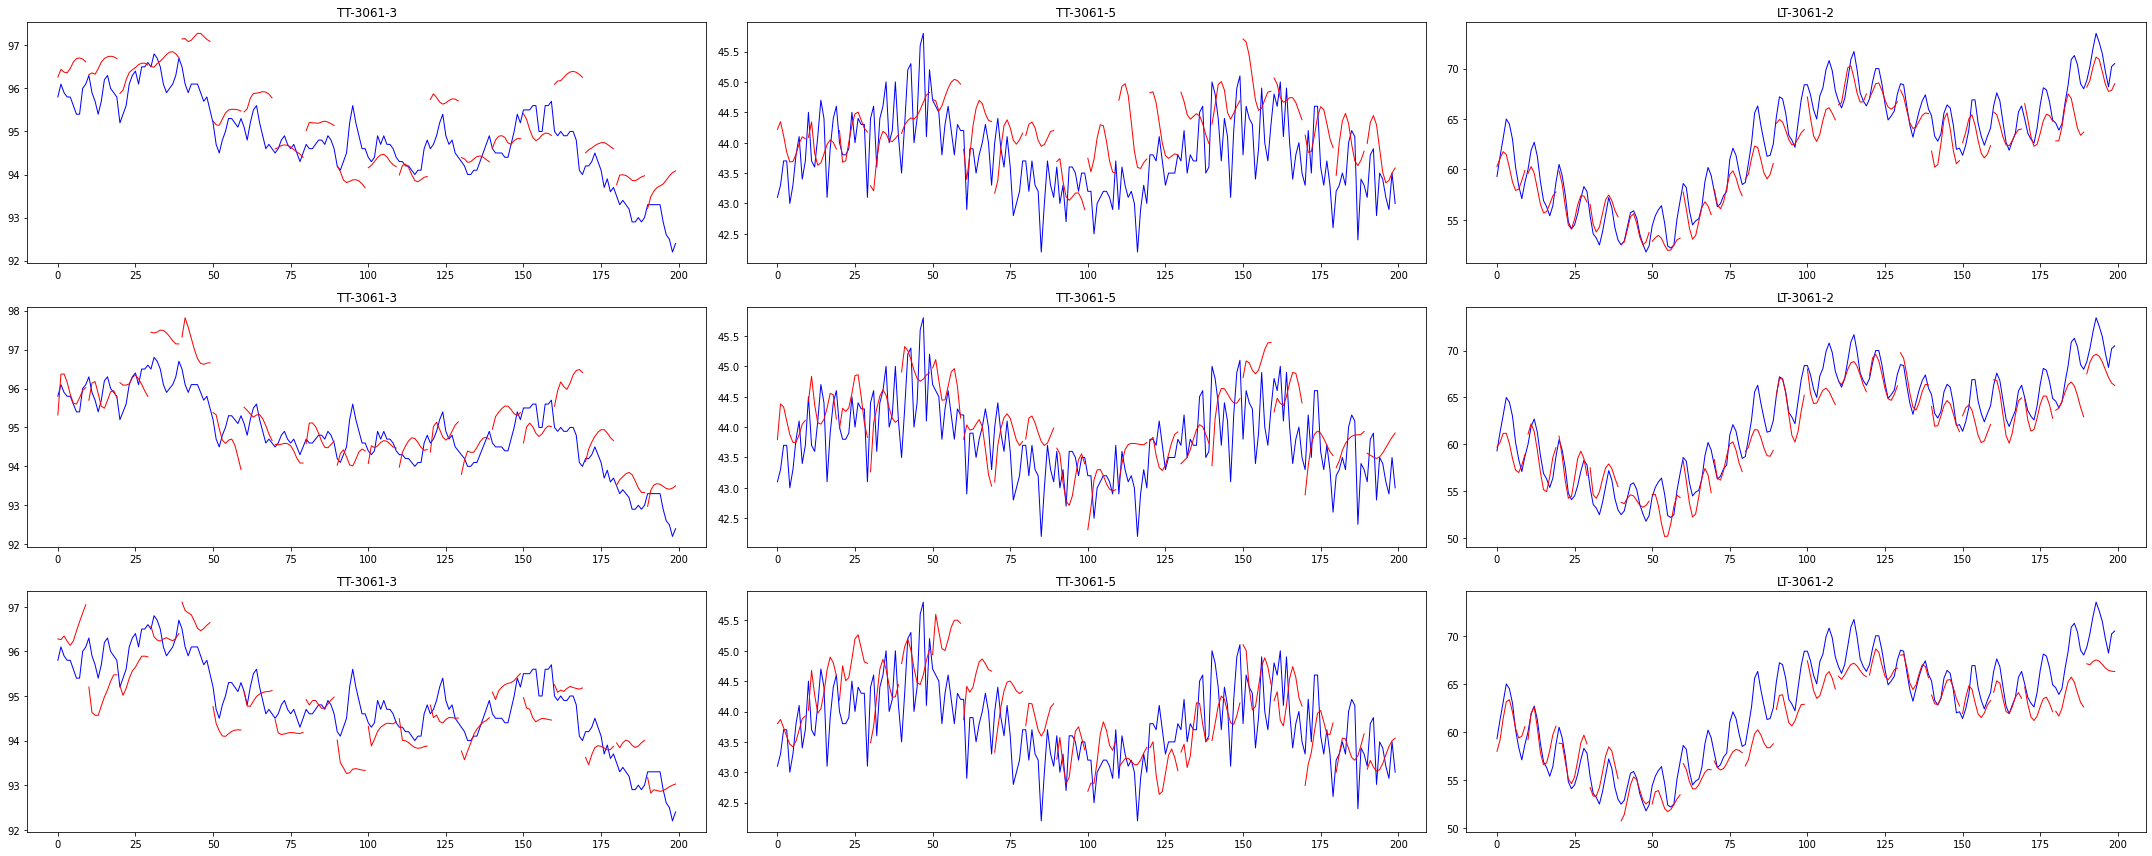

start_idx: 200


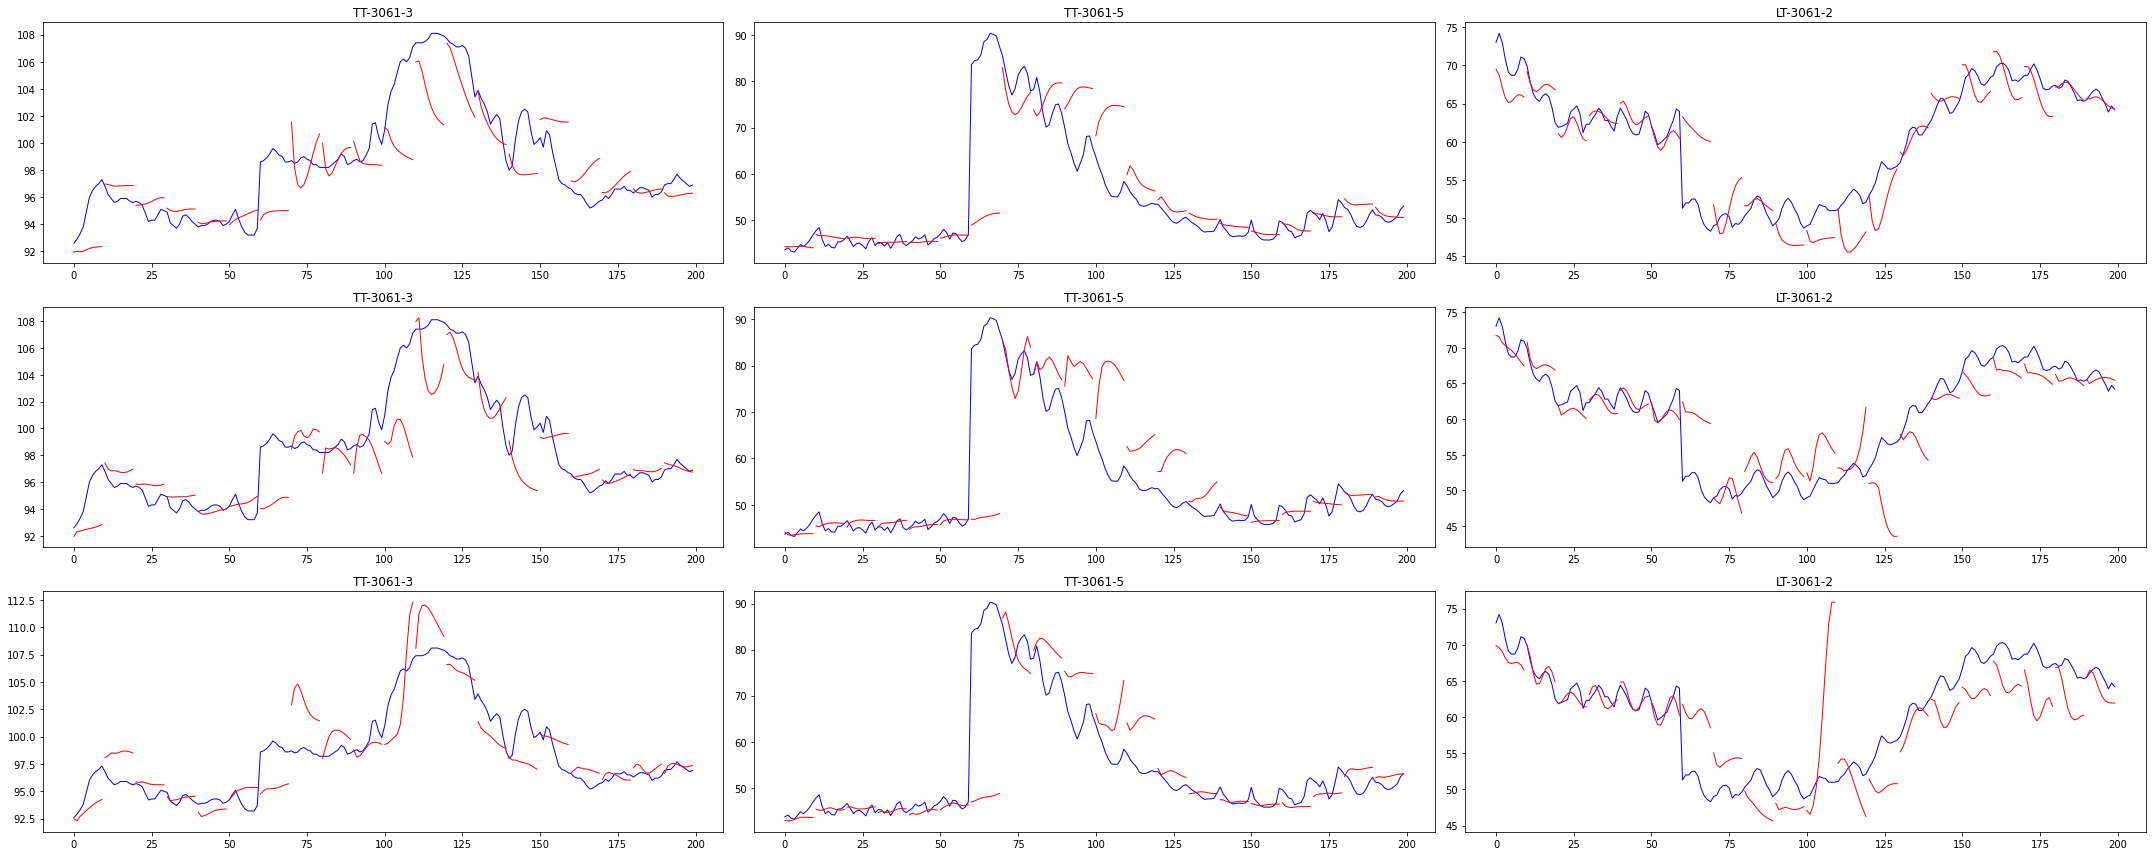

start_idx: 400


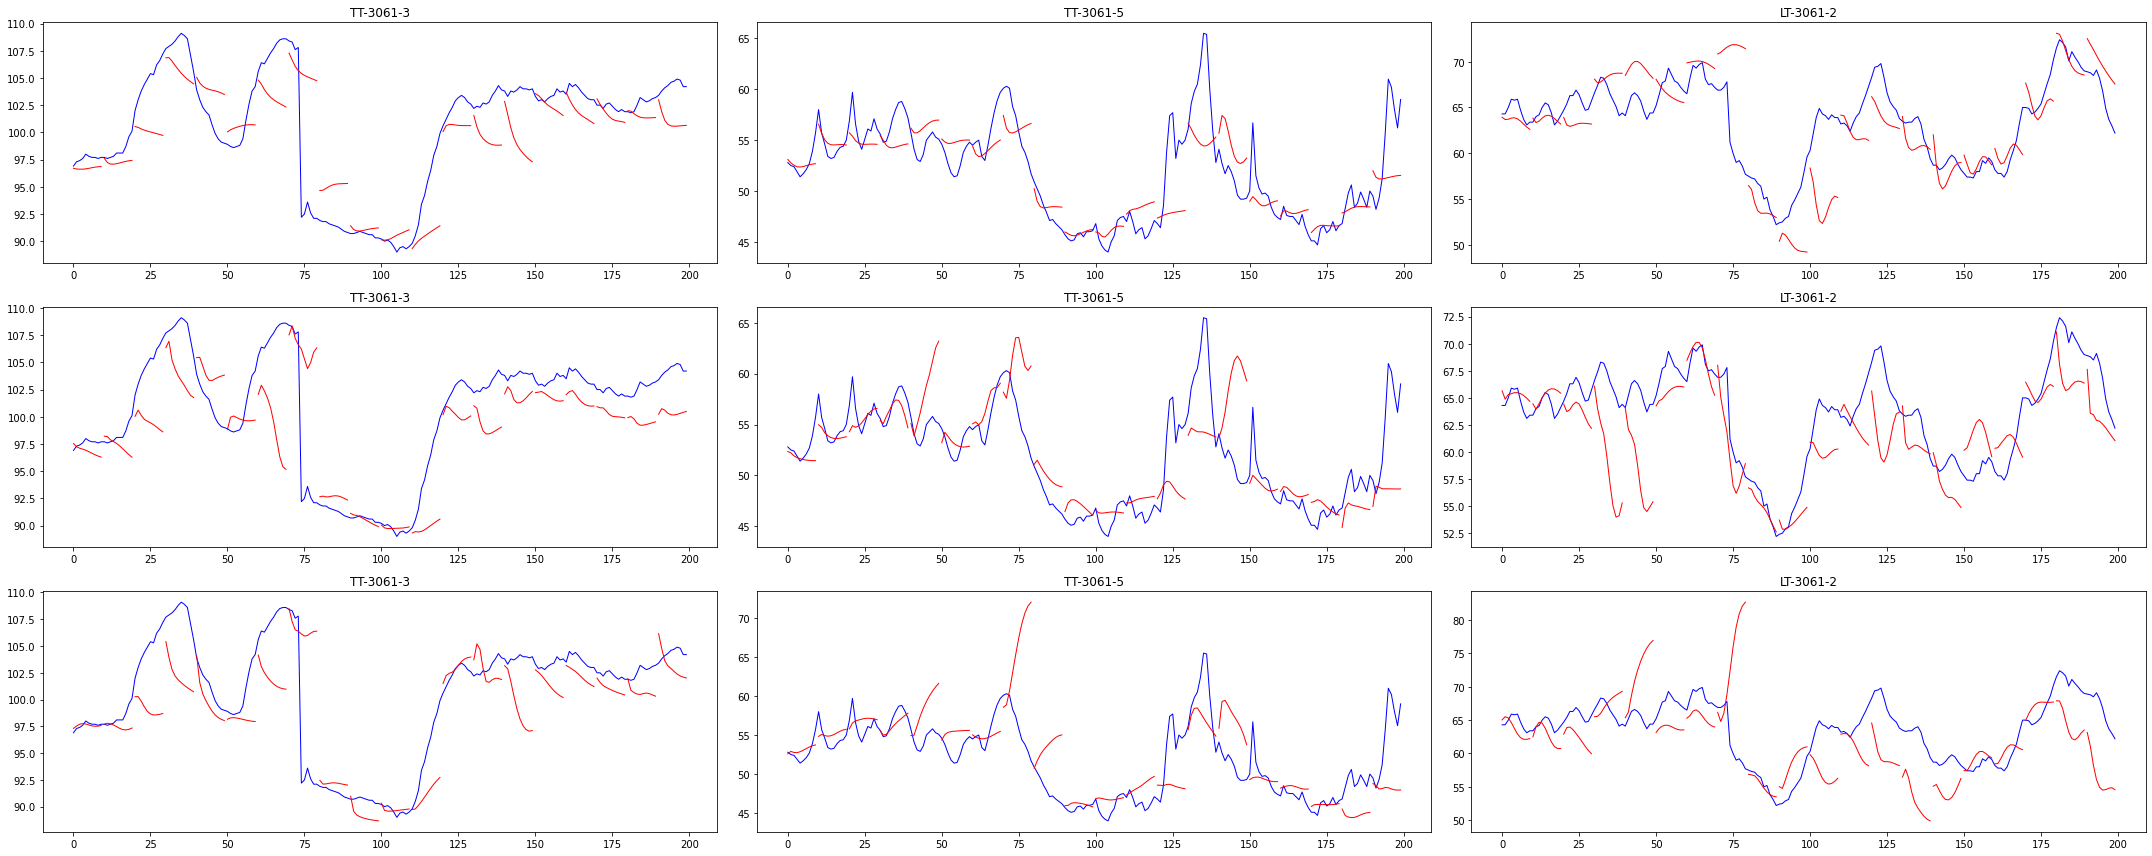

start_idx: 600


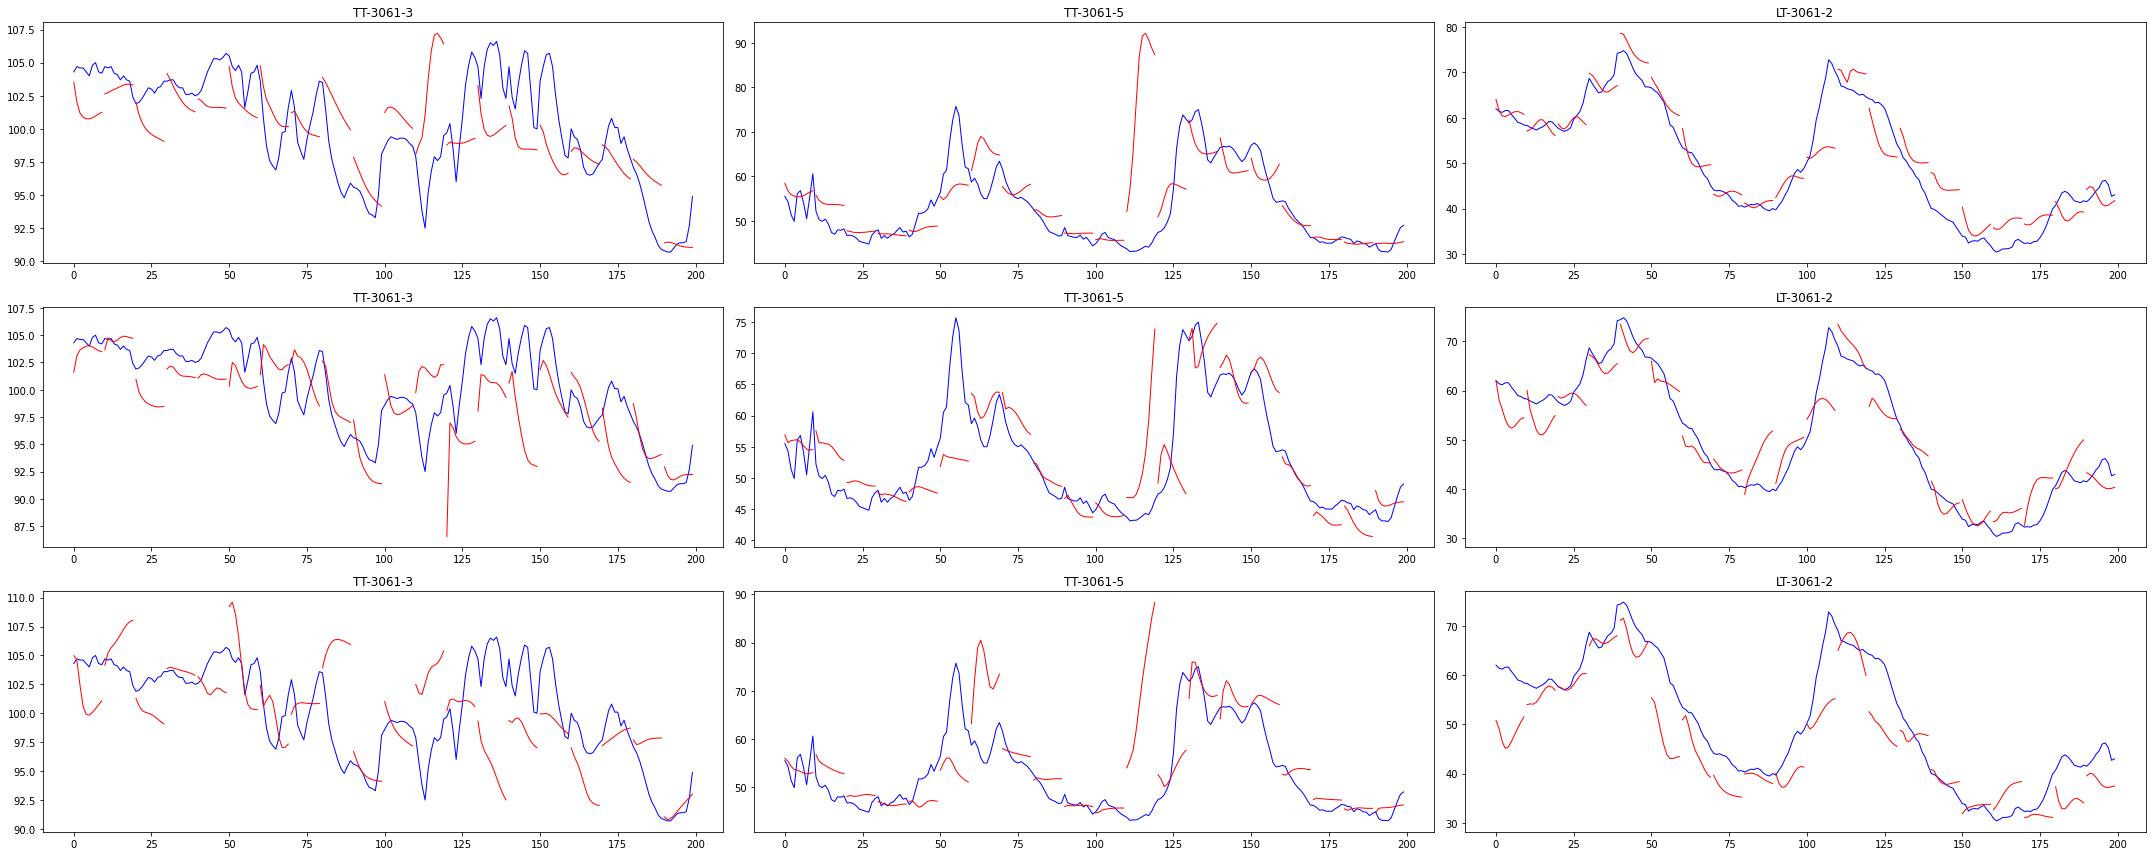

start_idx: 800


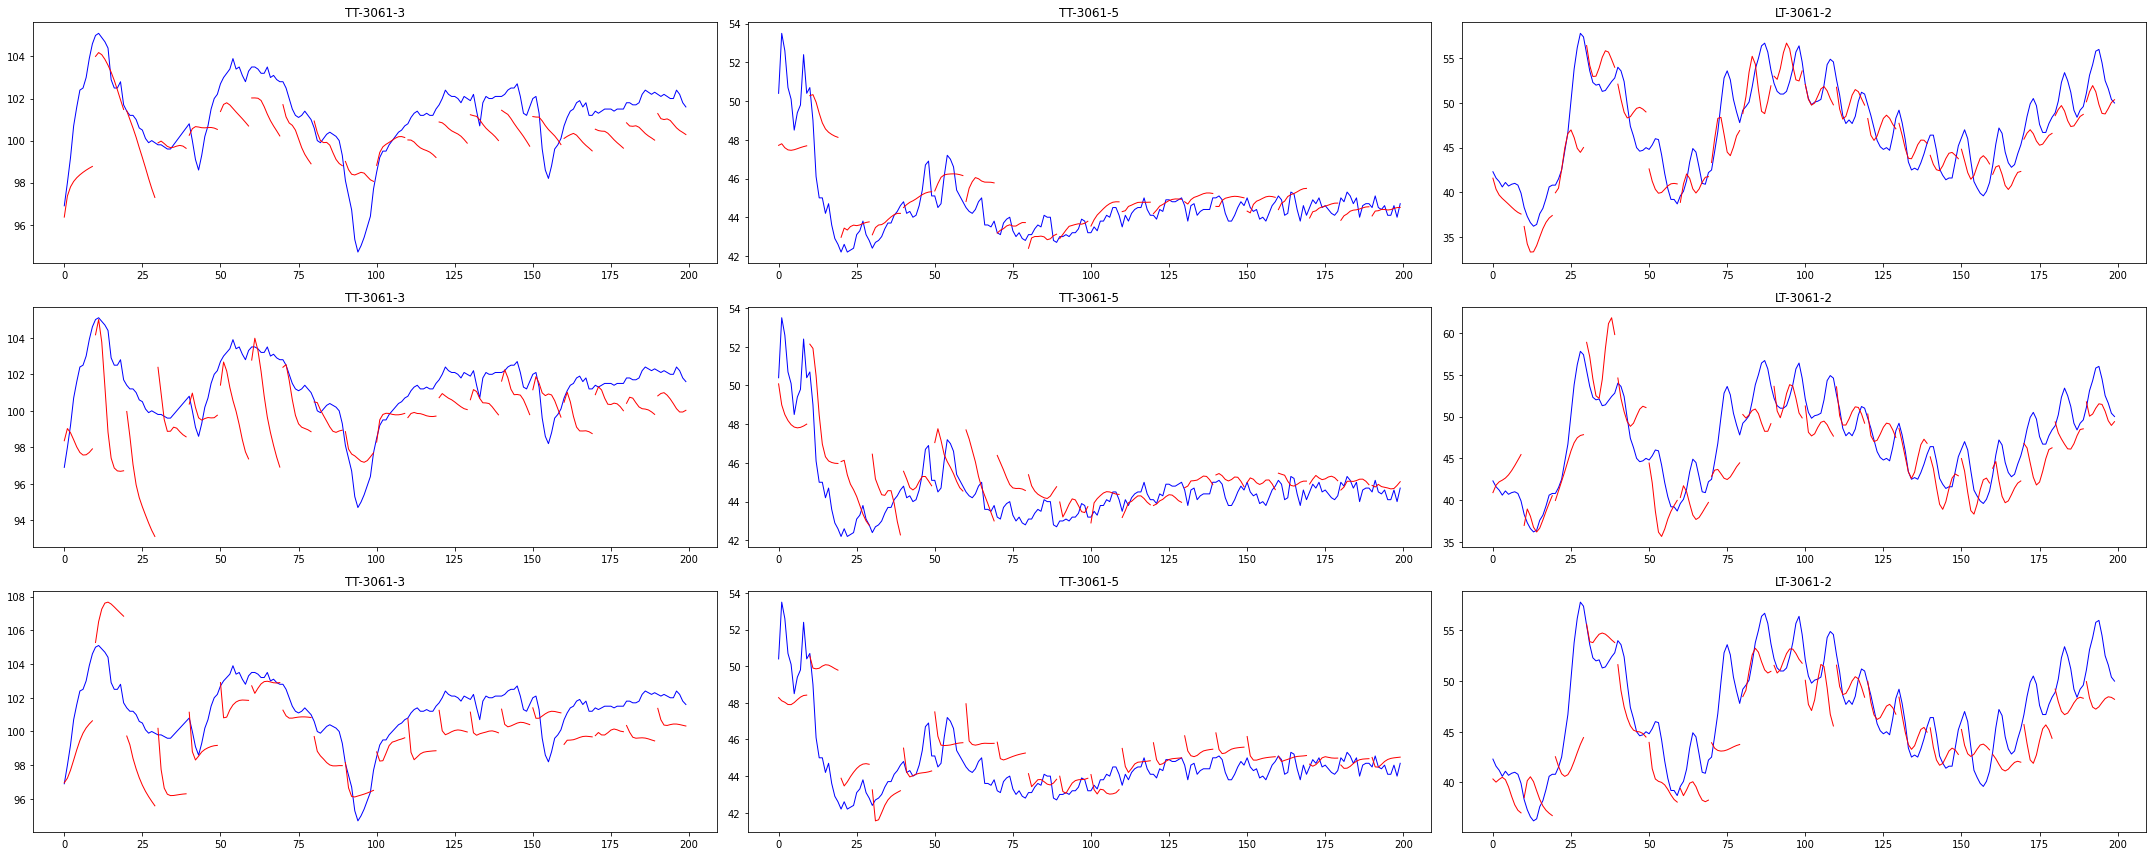

start_idx: 1000


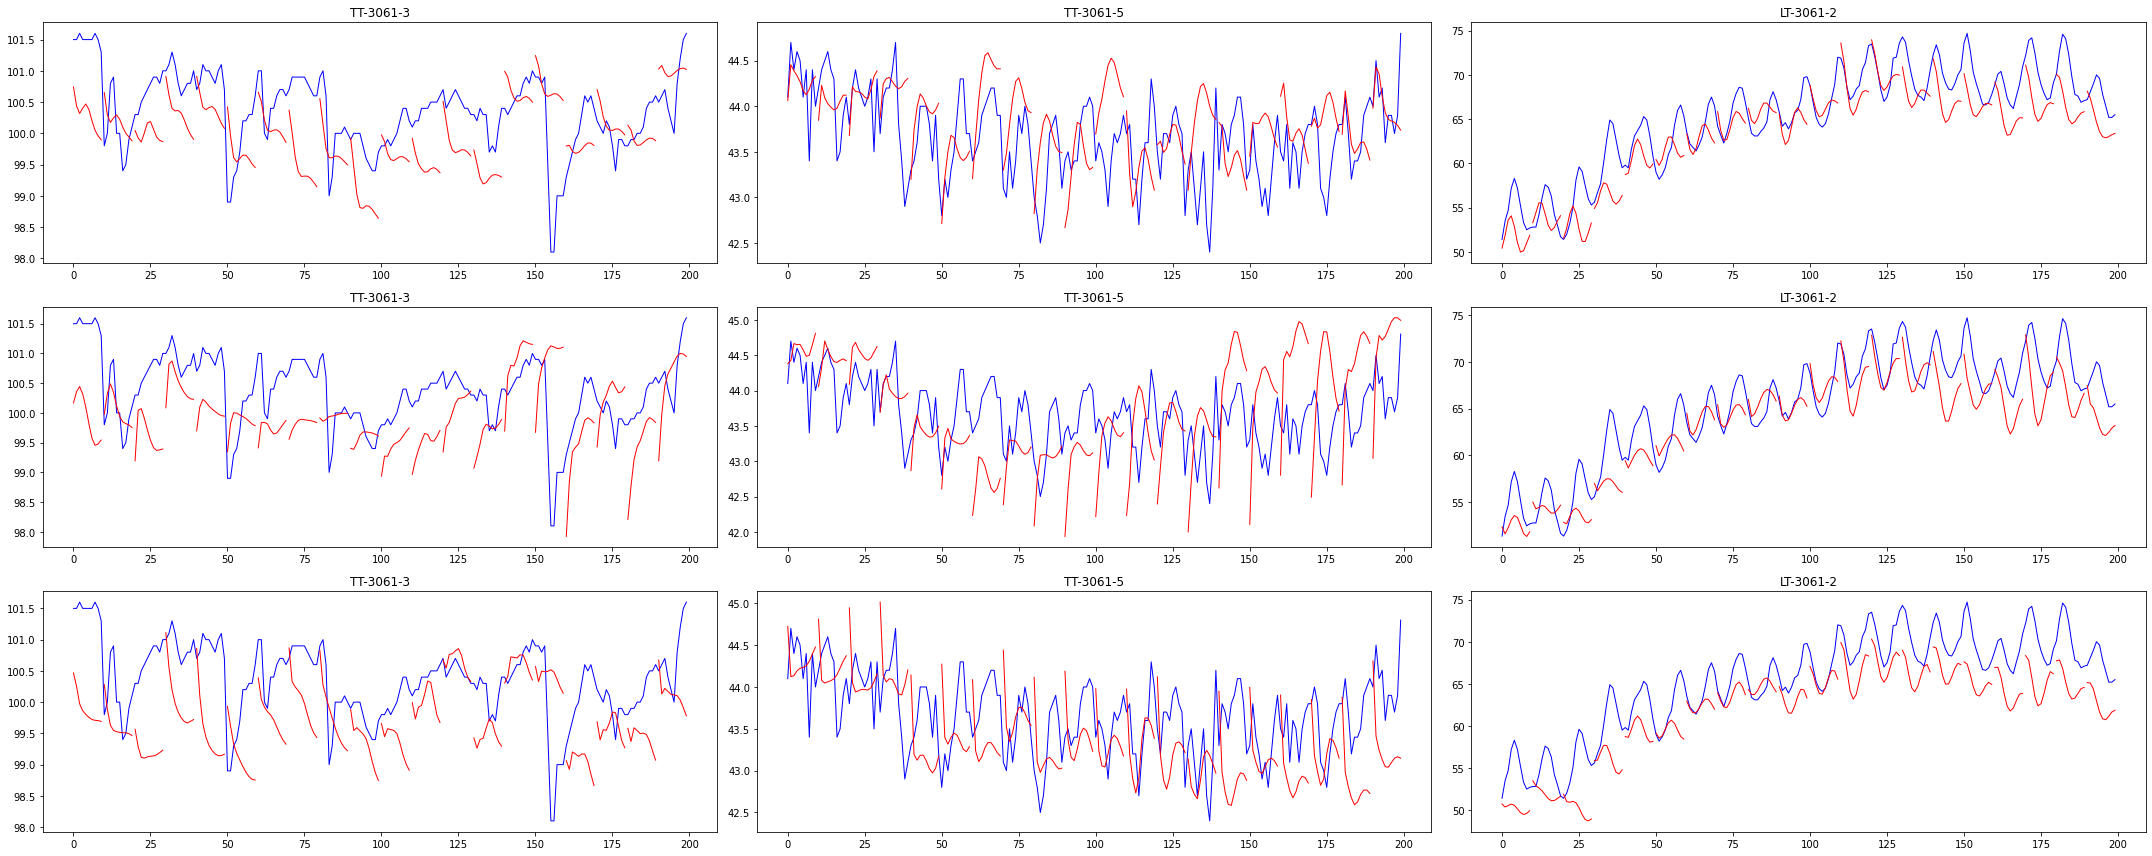

start_idx: 1200


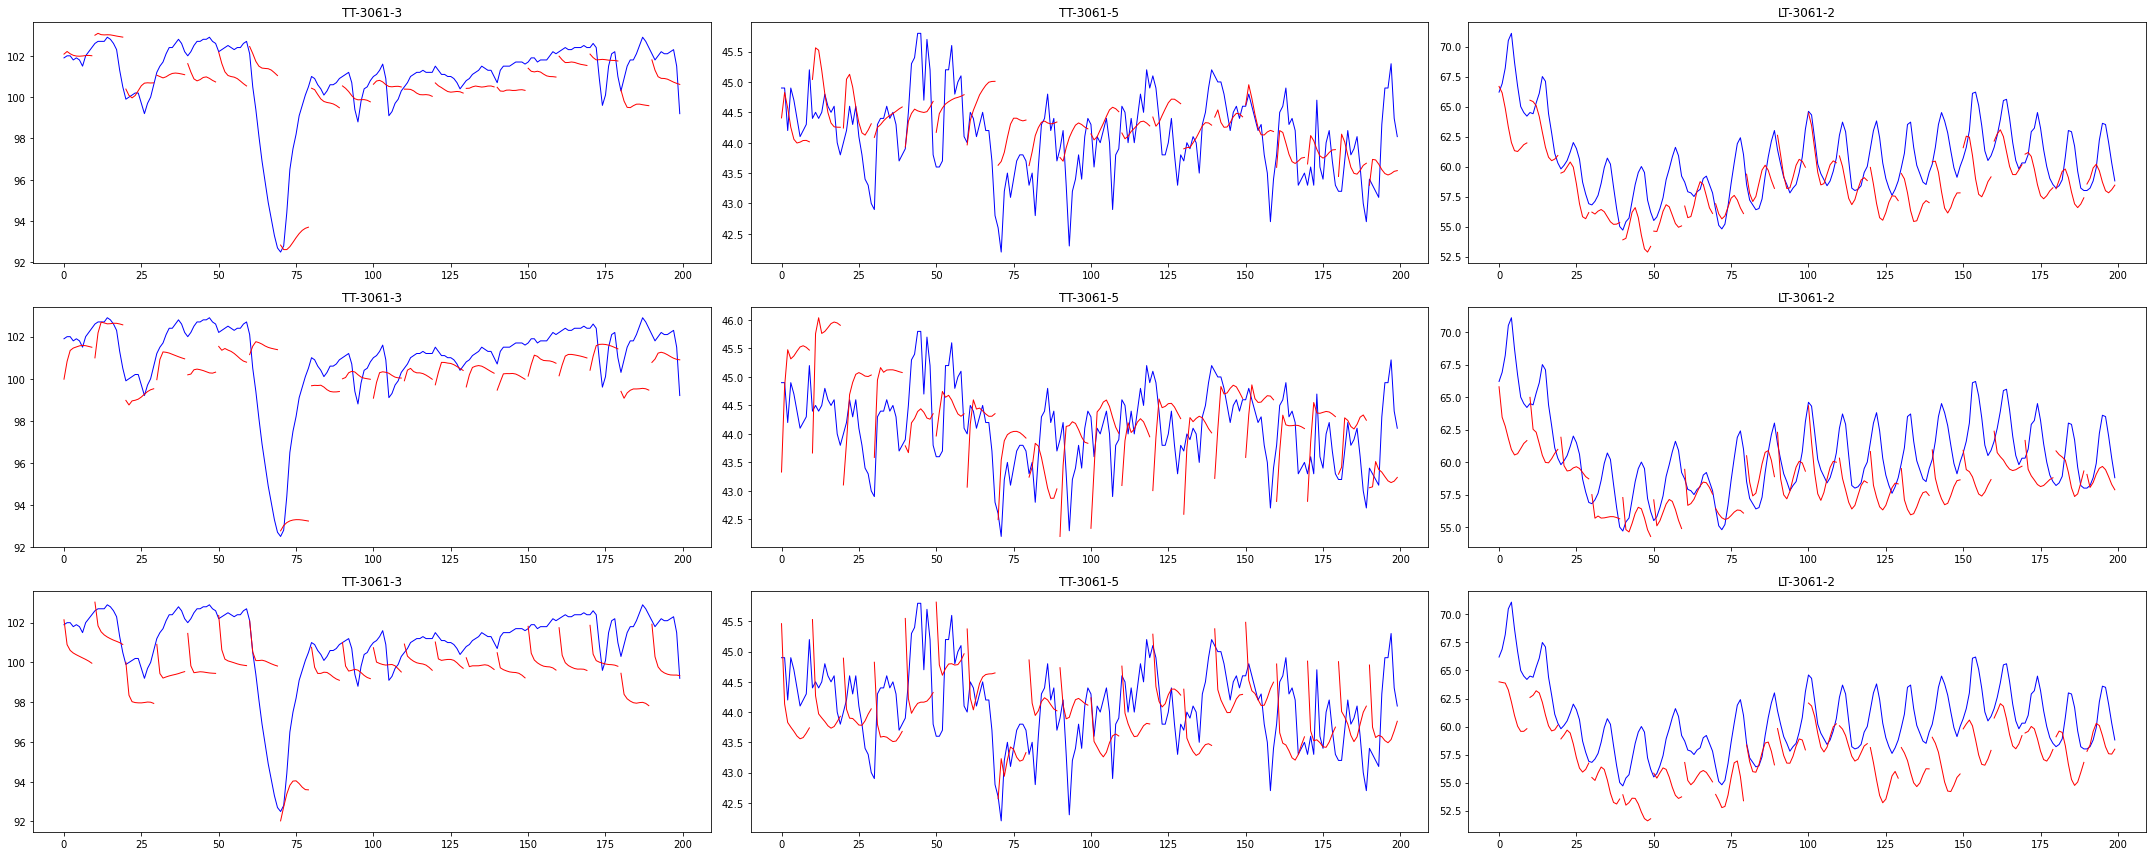

start_idx: 1400


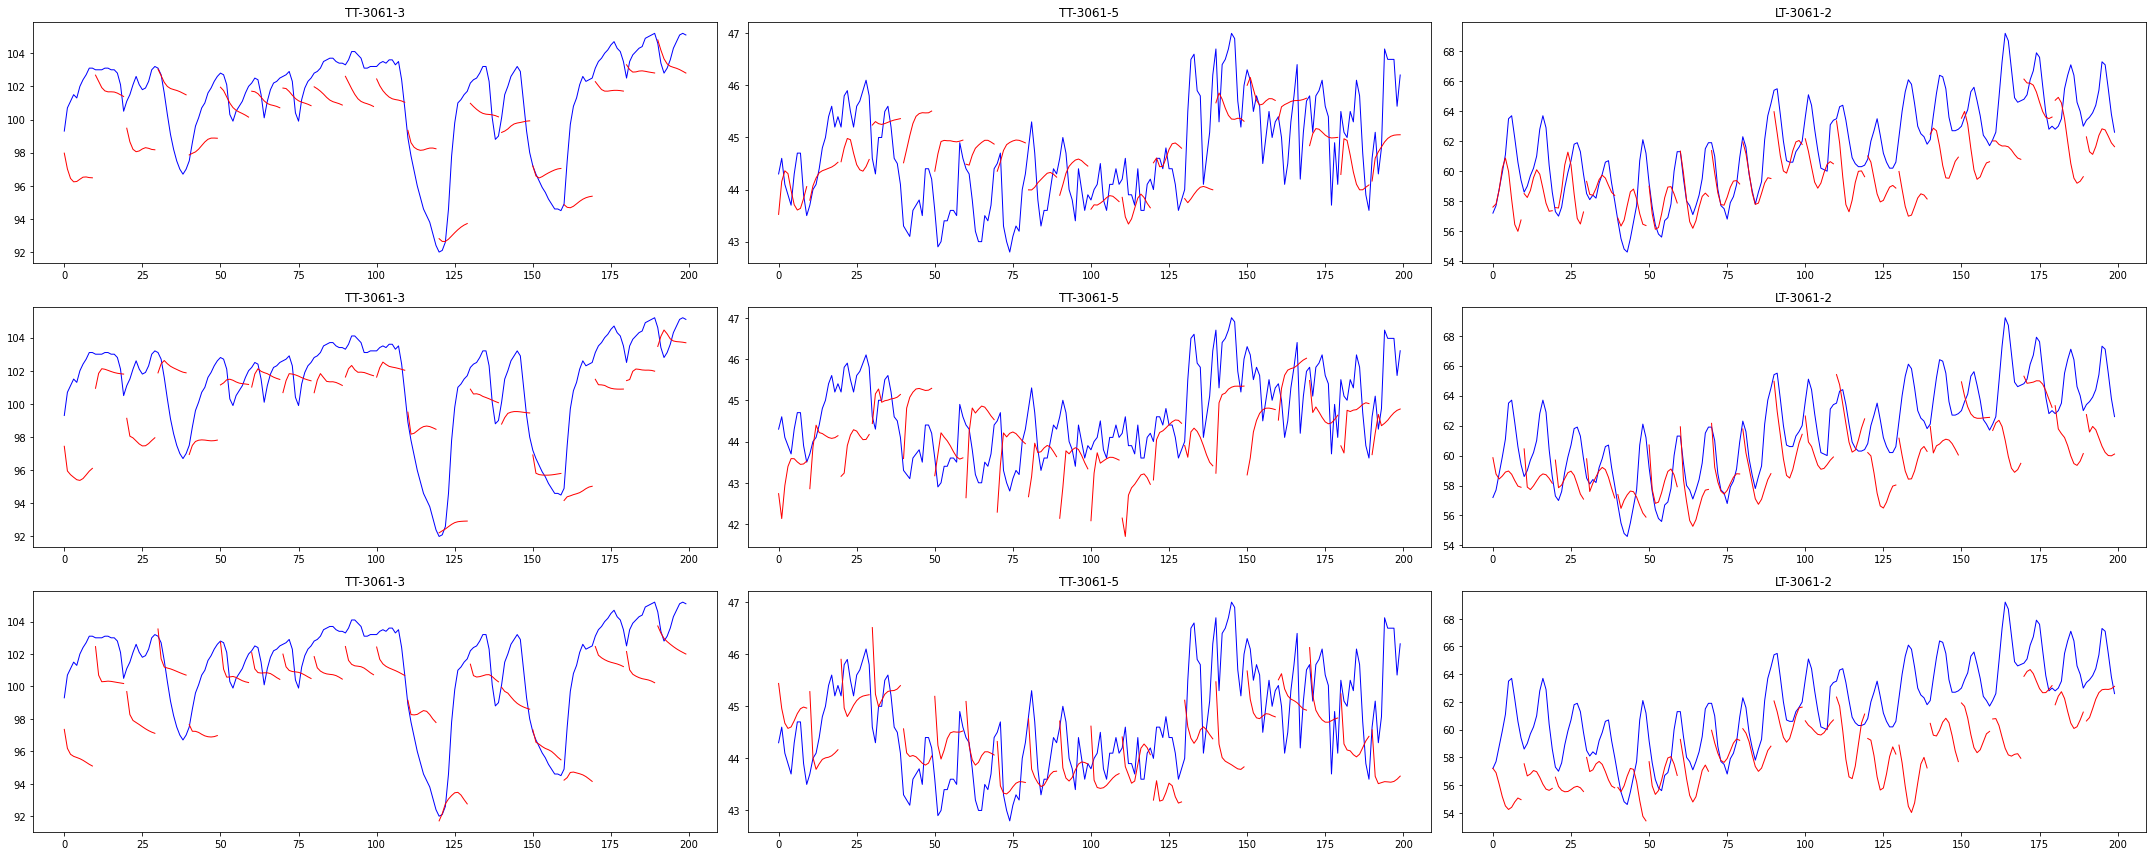

start_idx: 1600


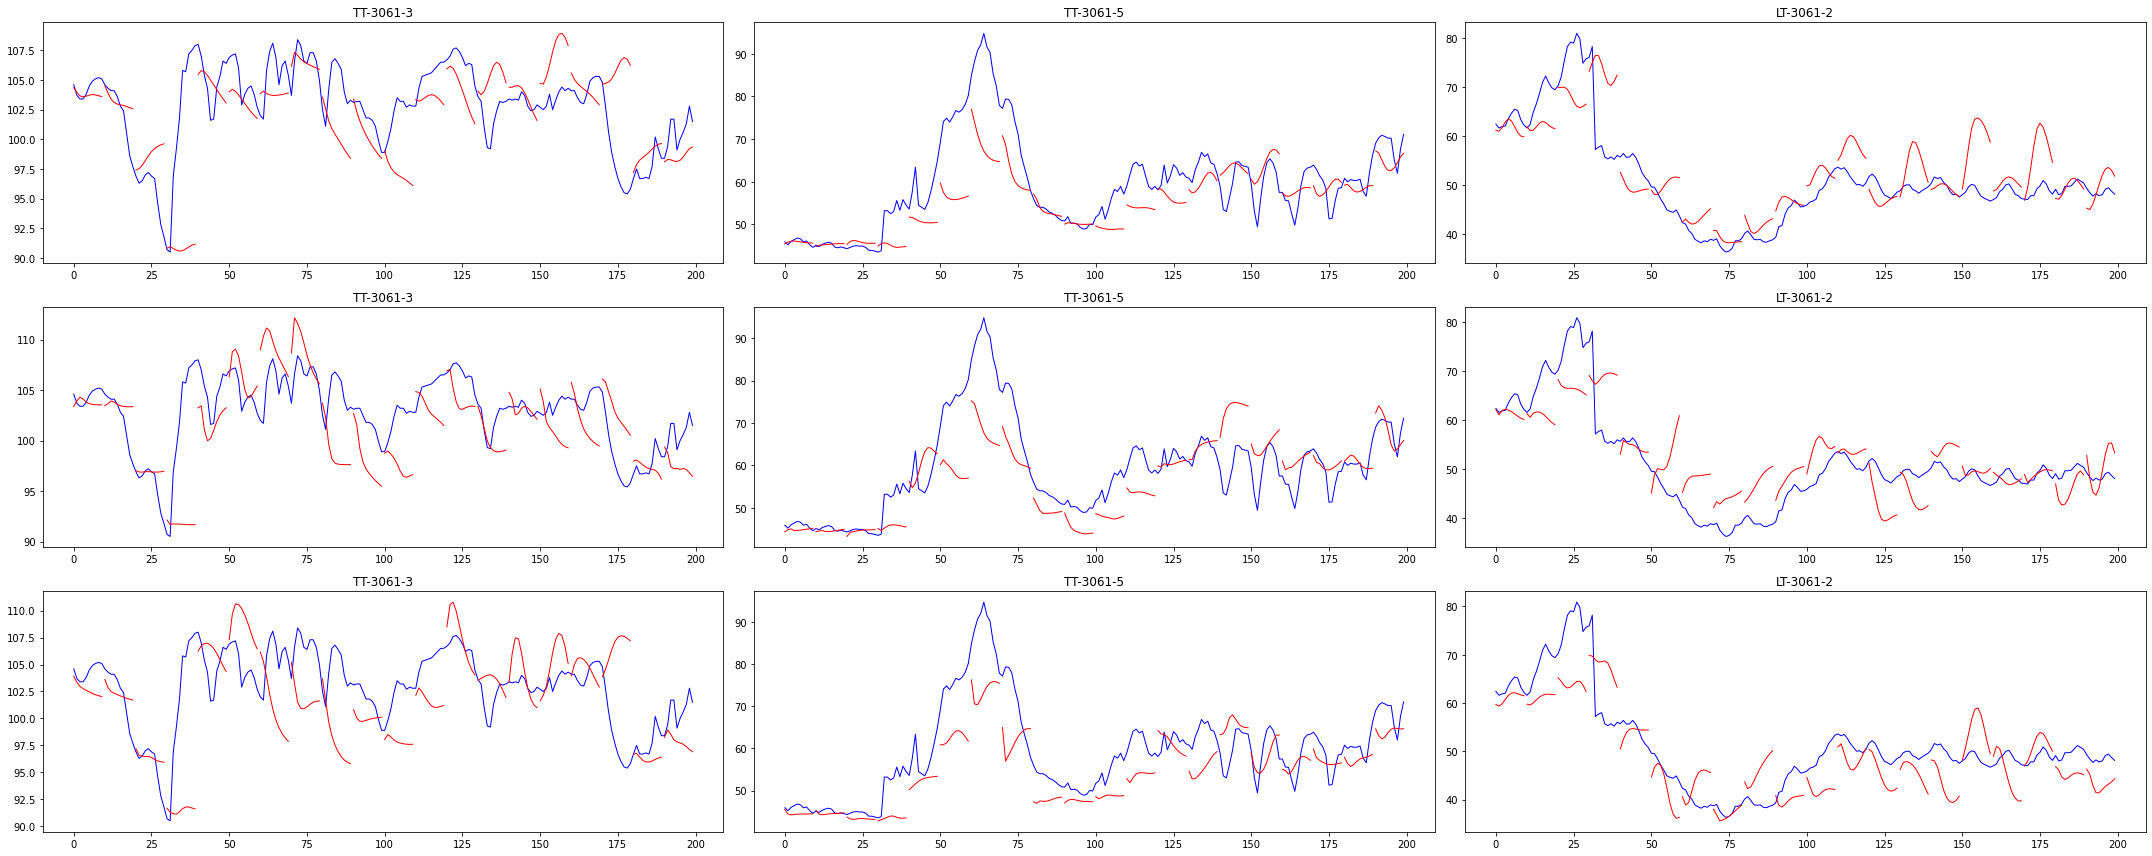

start_idx: 1800


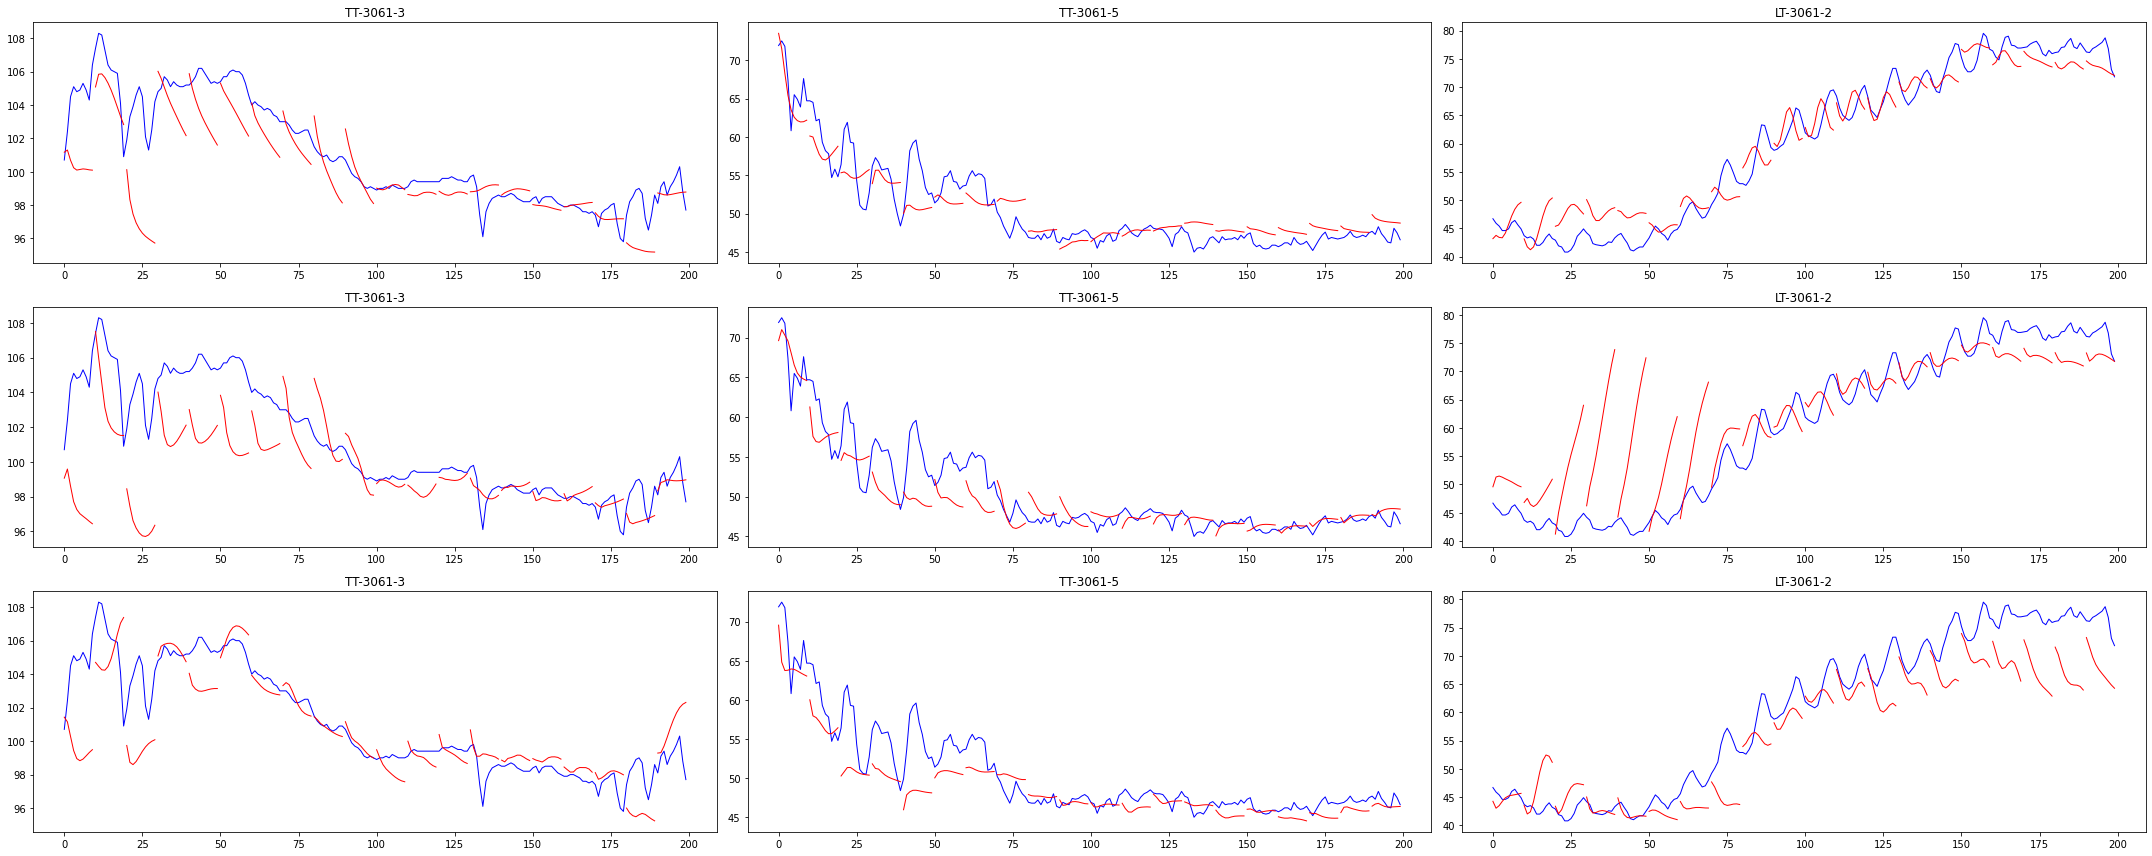

start_idx: 2000


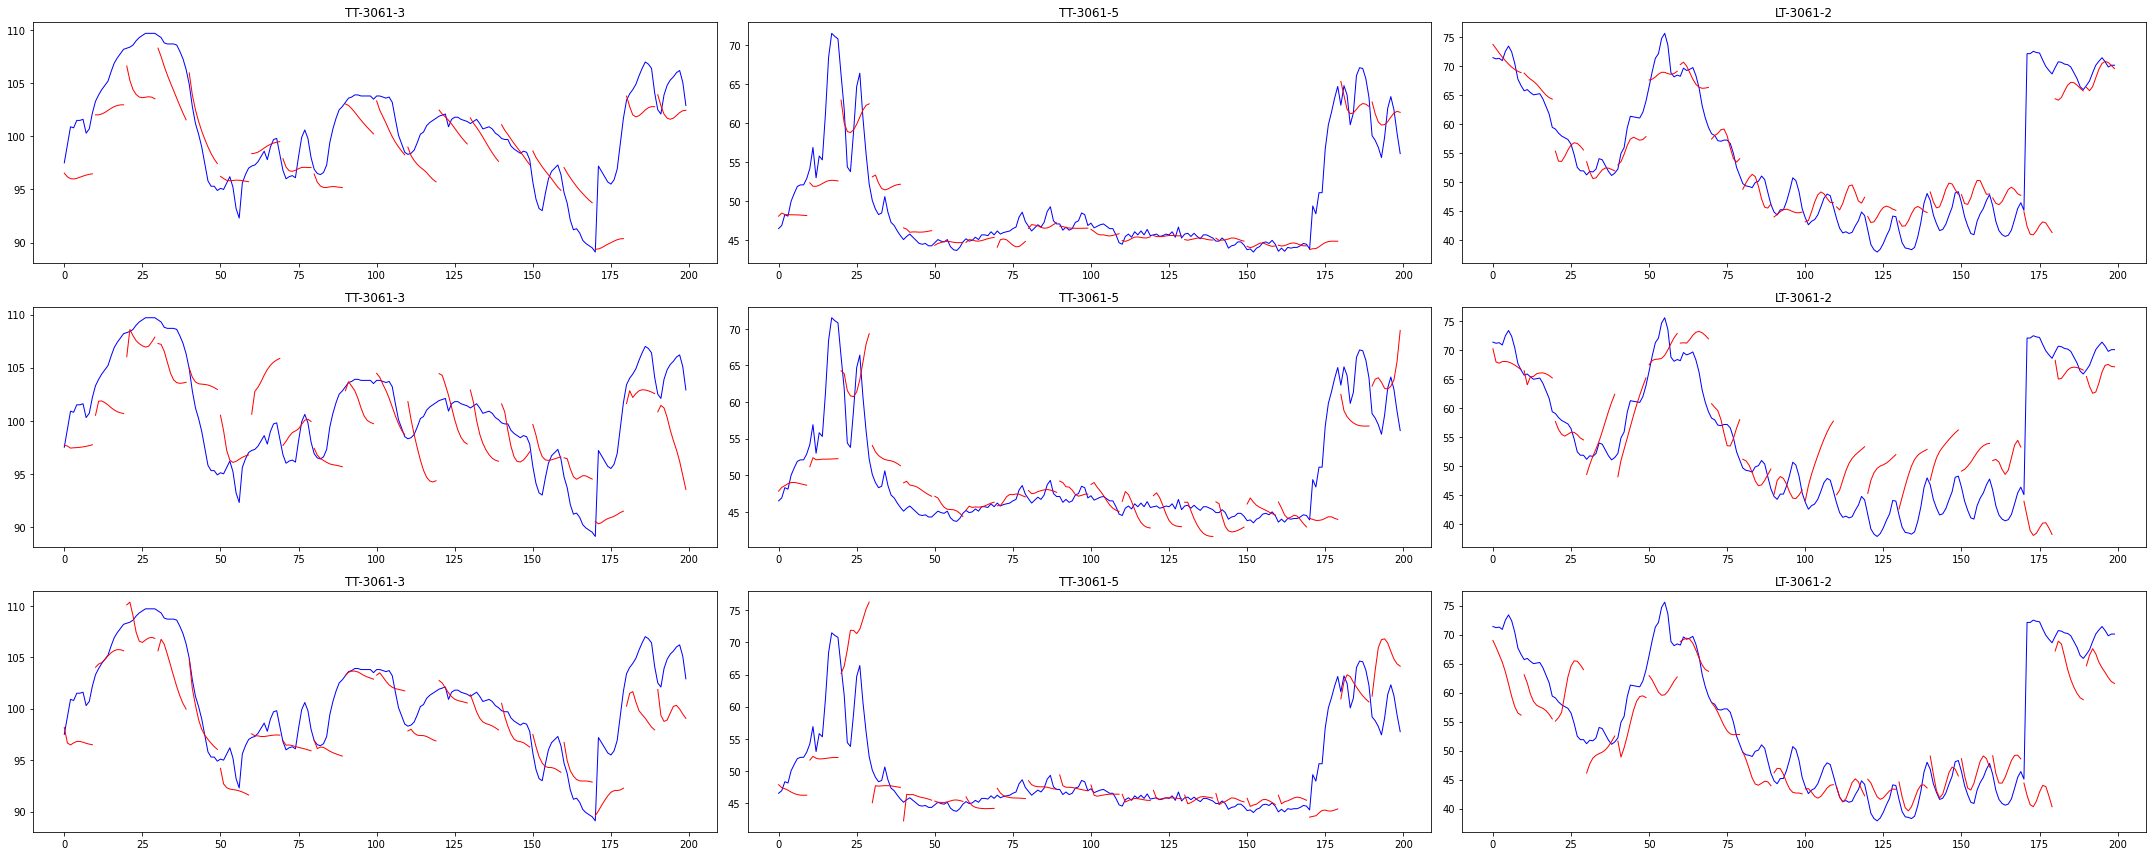

start_idx: 2200


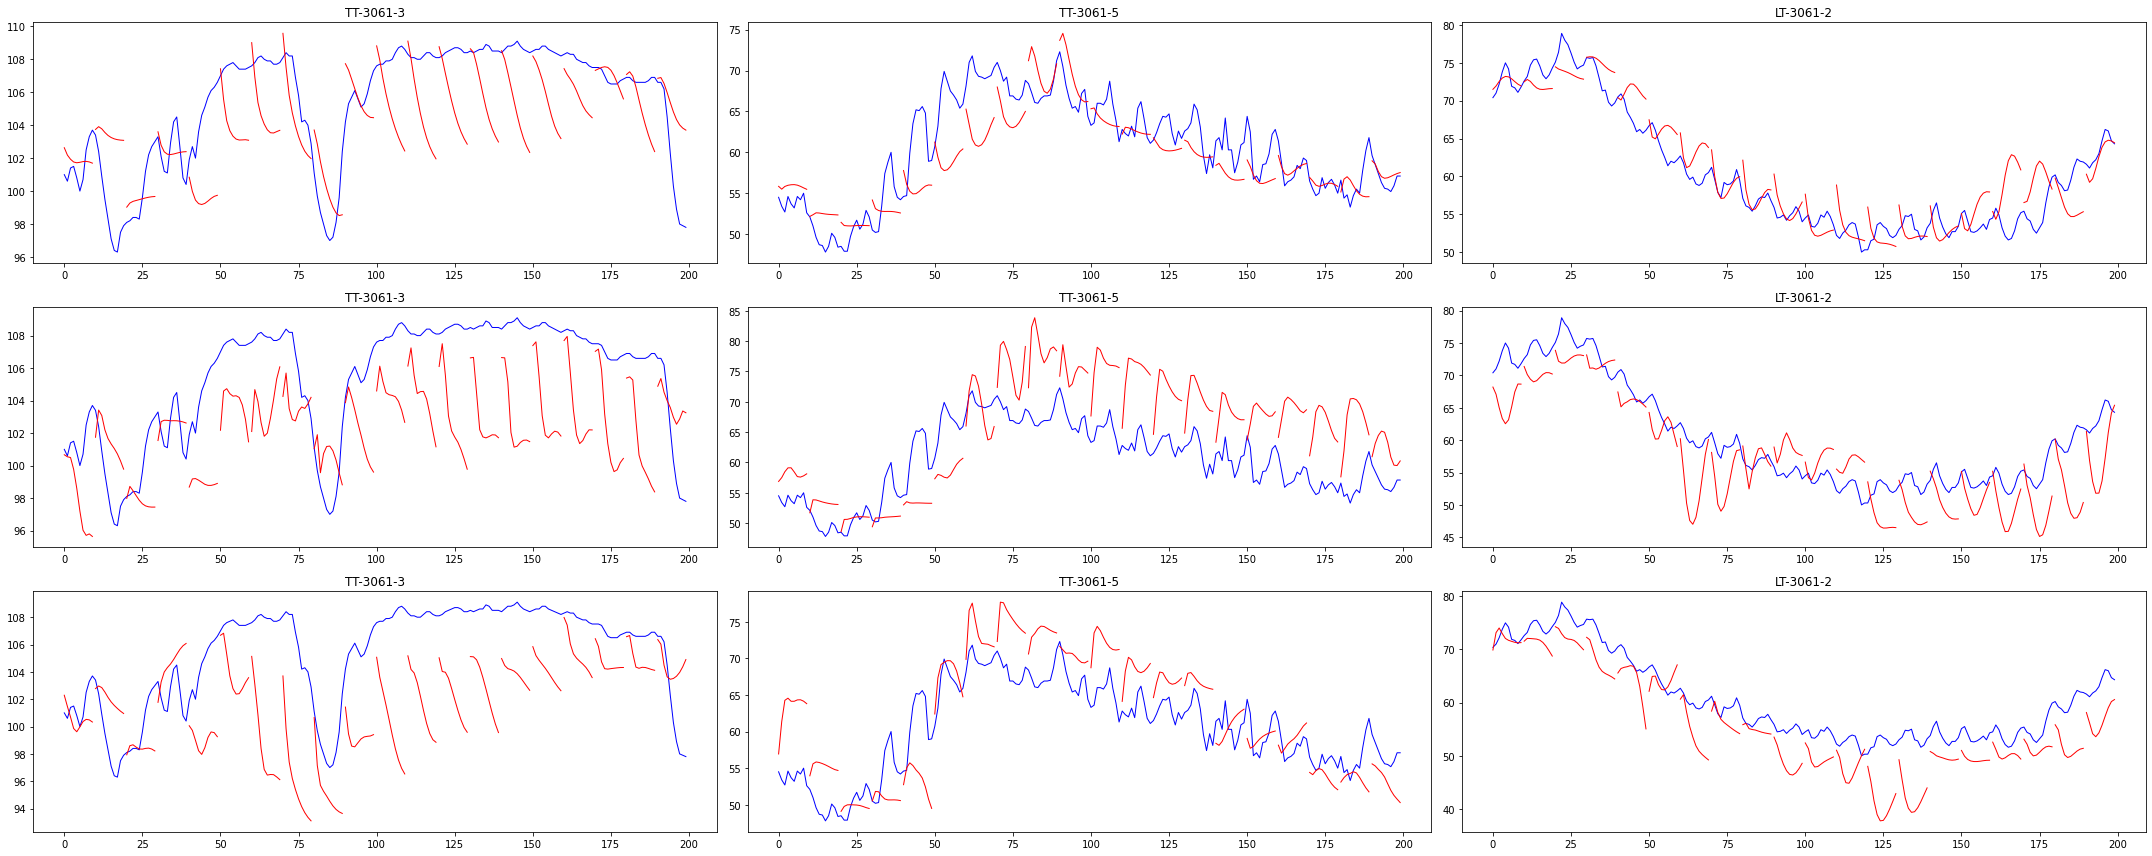

start_idx: 2400


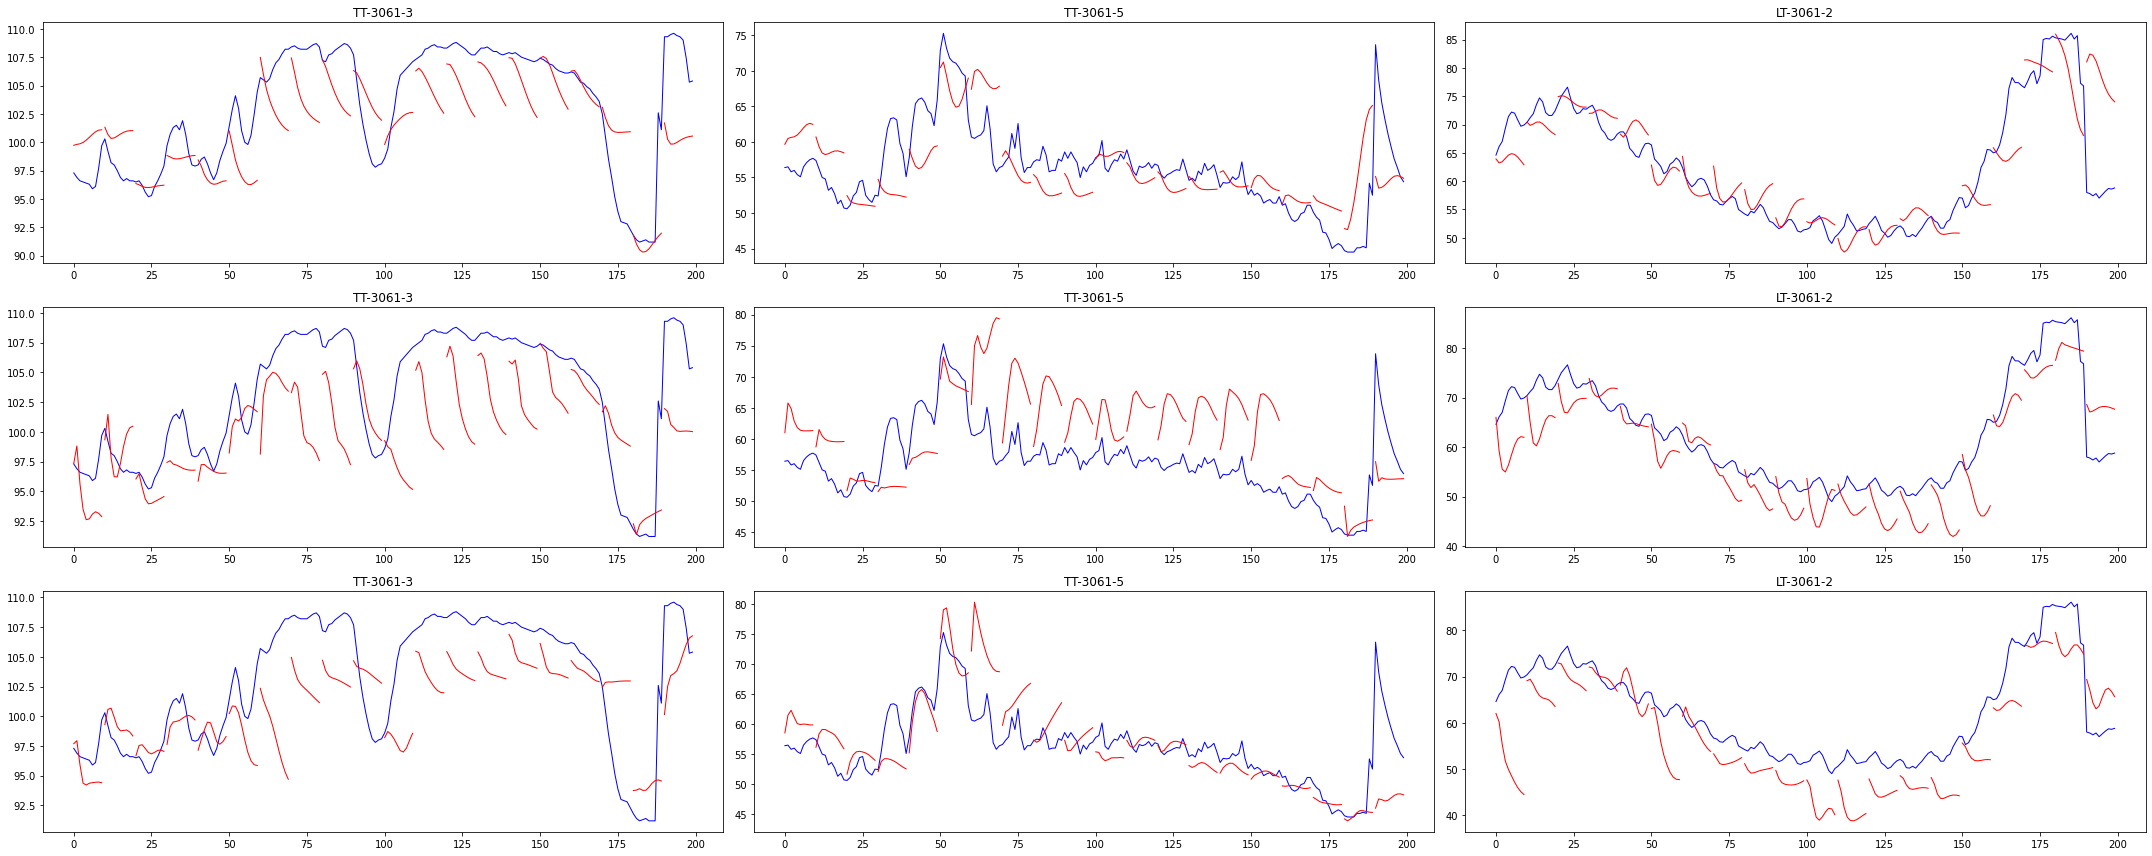

start_idx: 2600


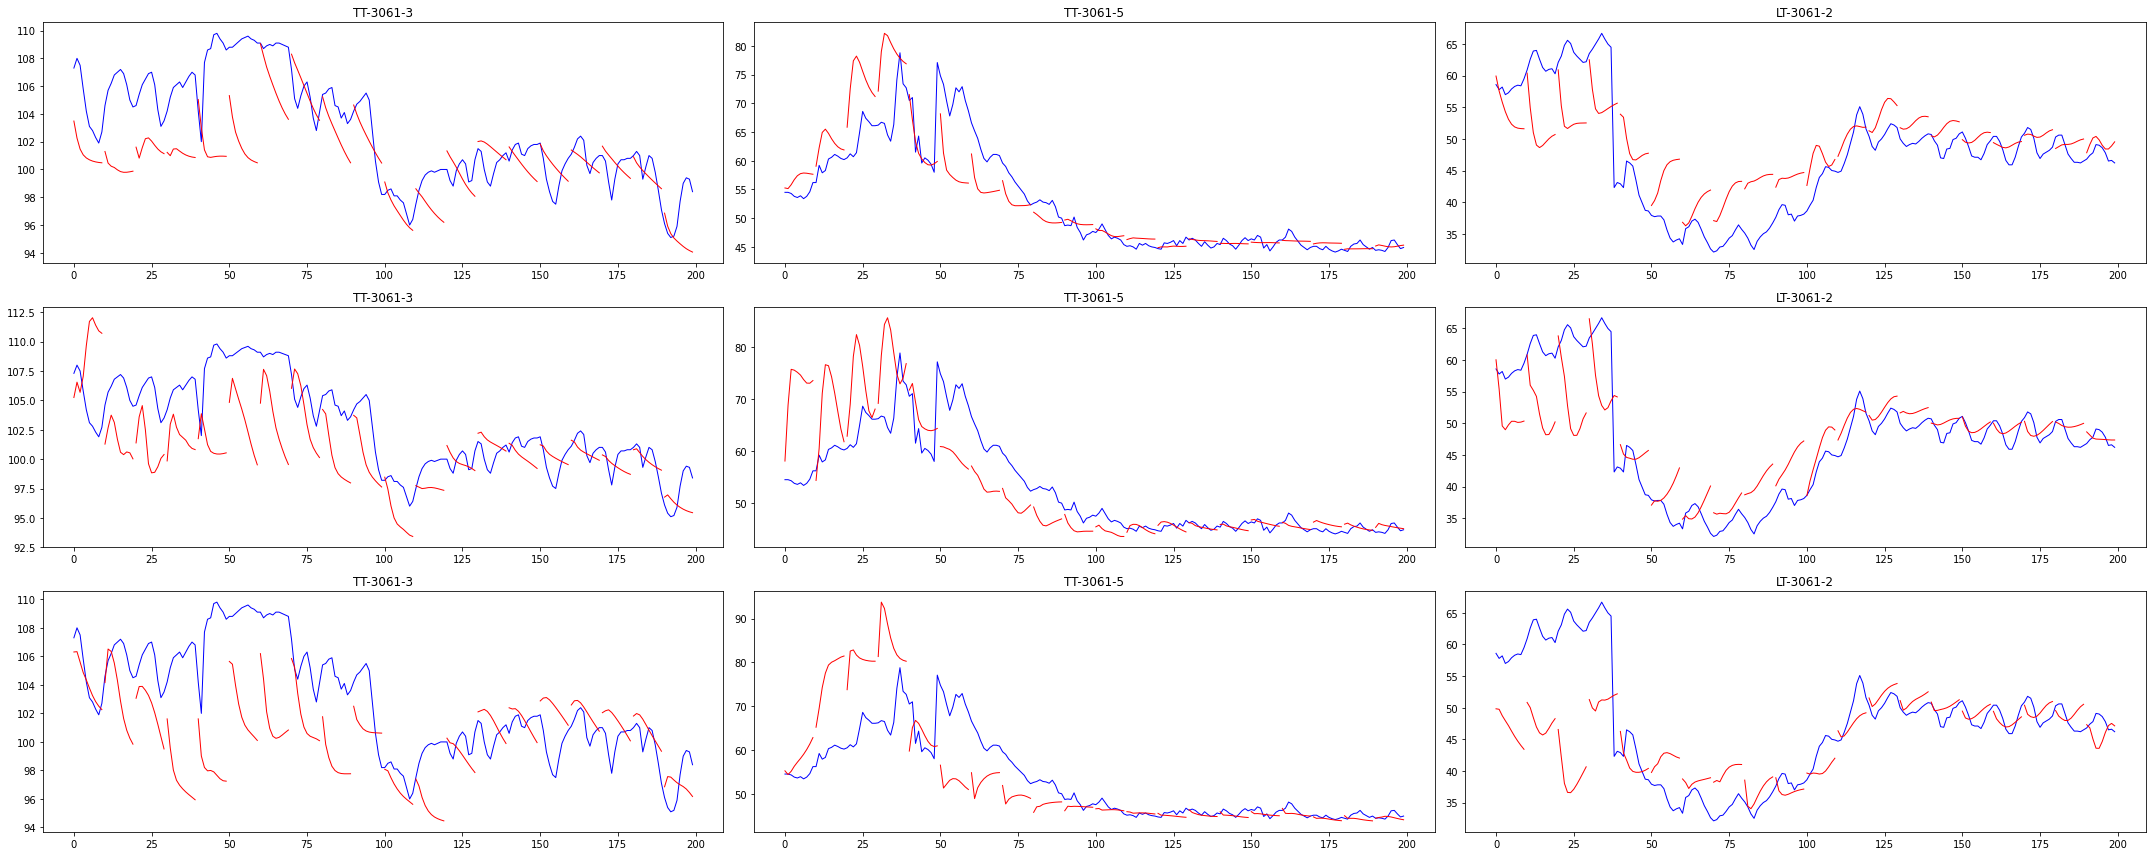

start_idx: 2800


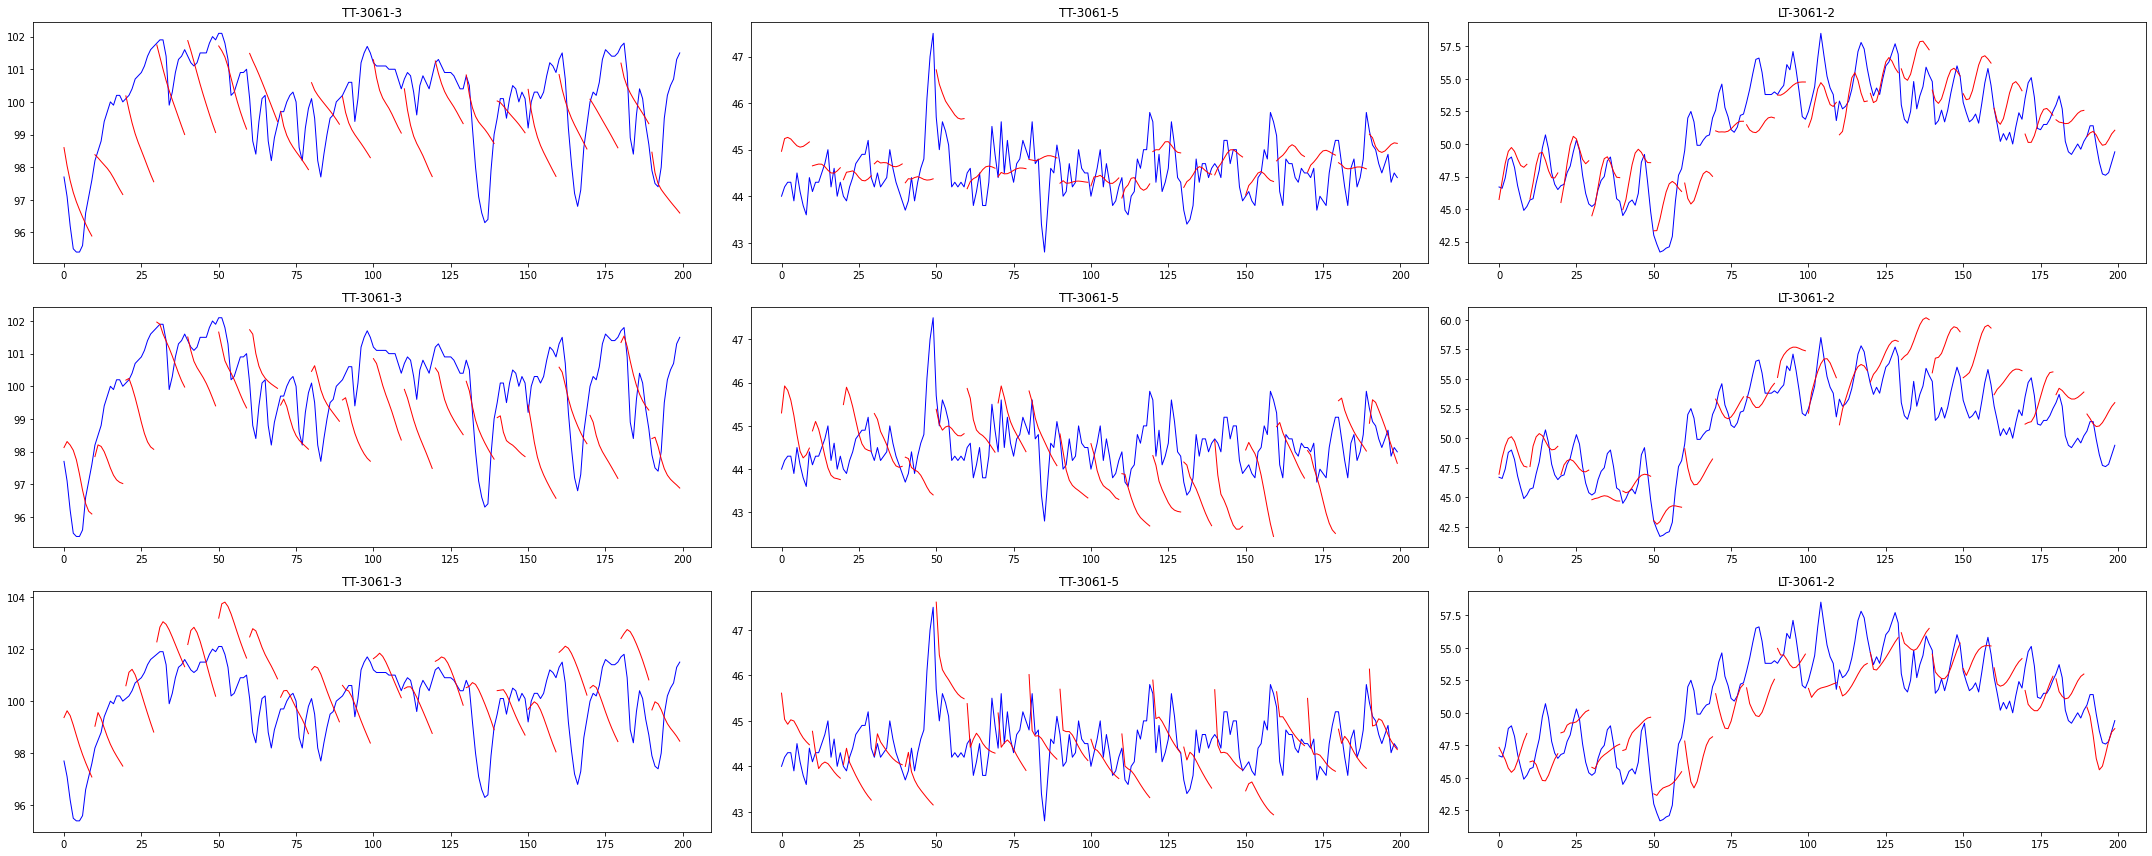

start_idx: 3000


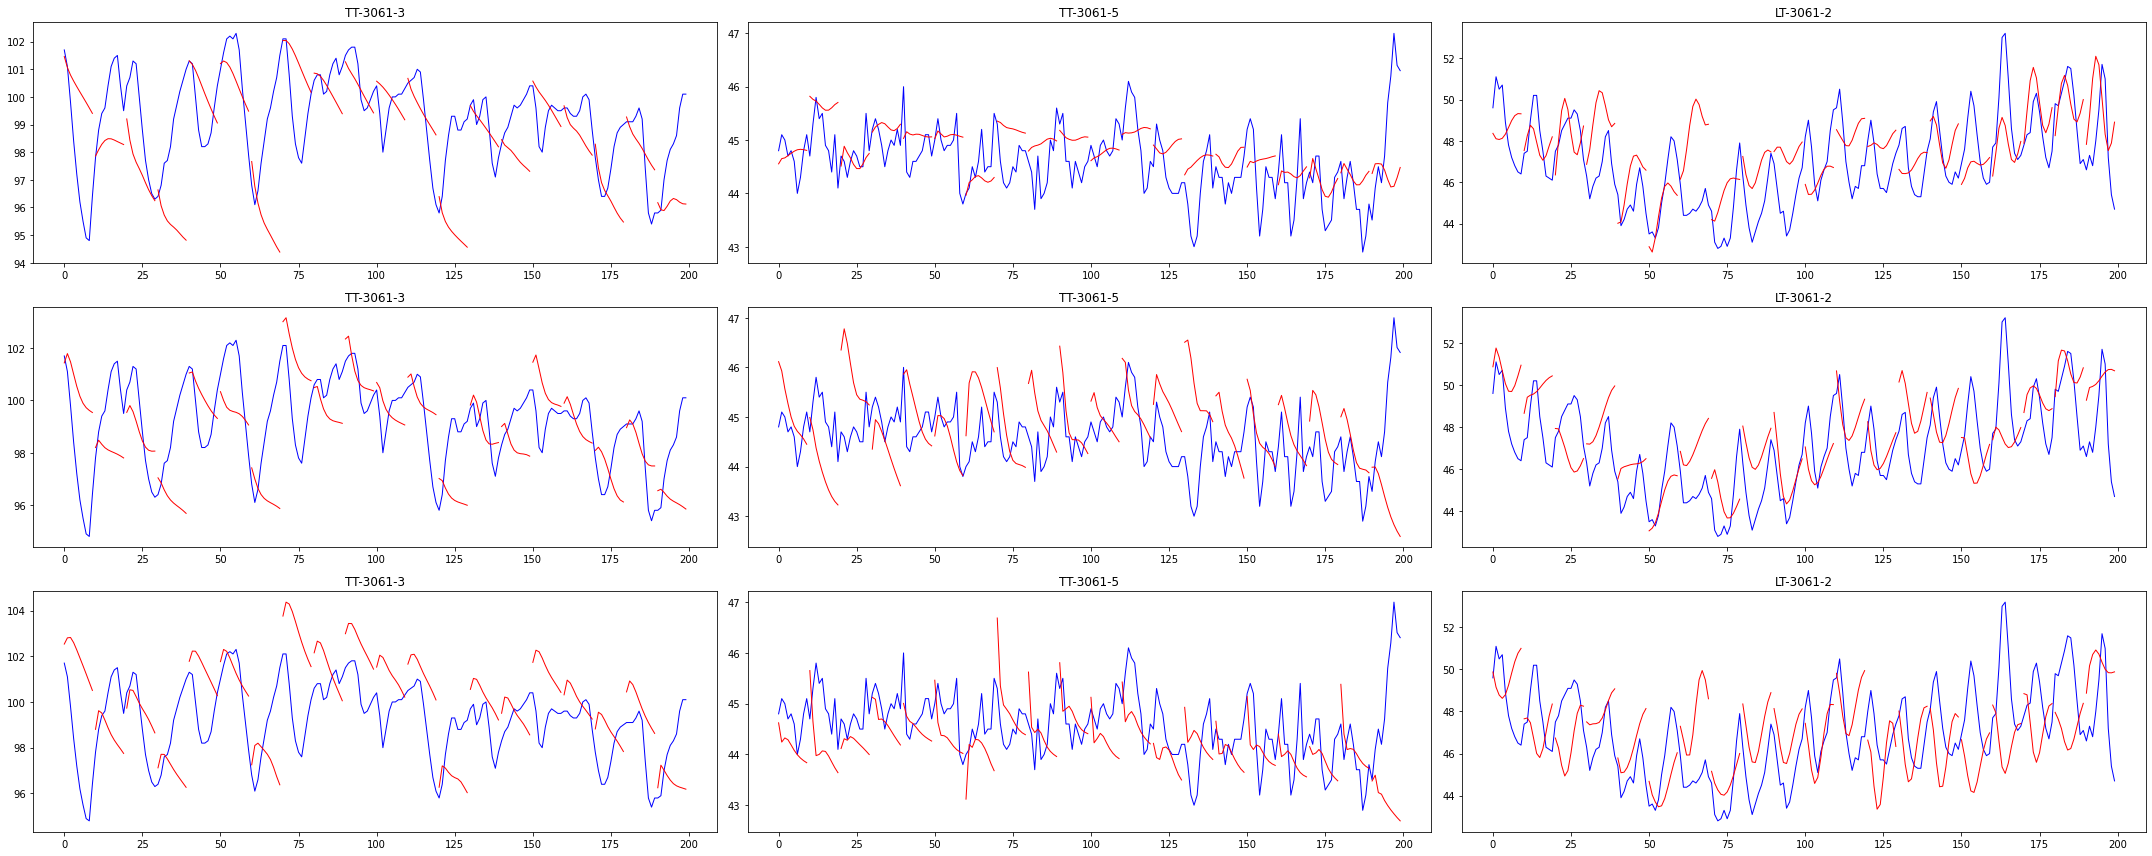

start_idx: 3200


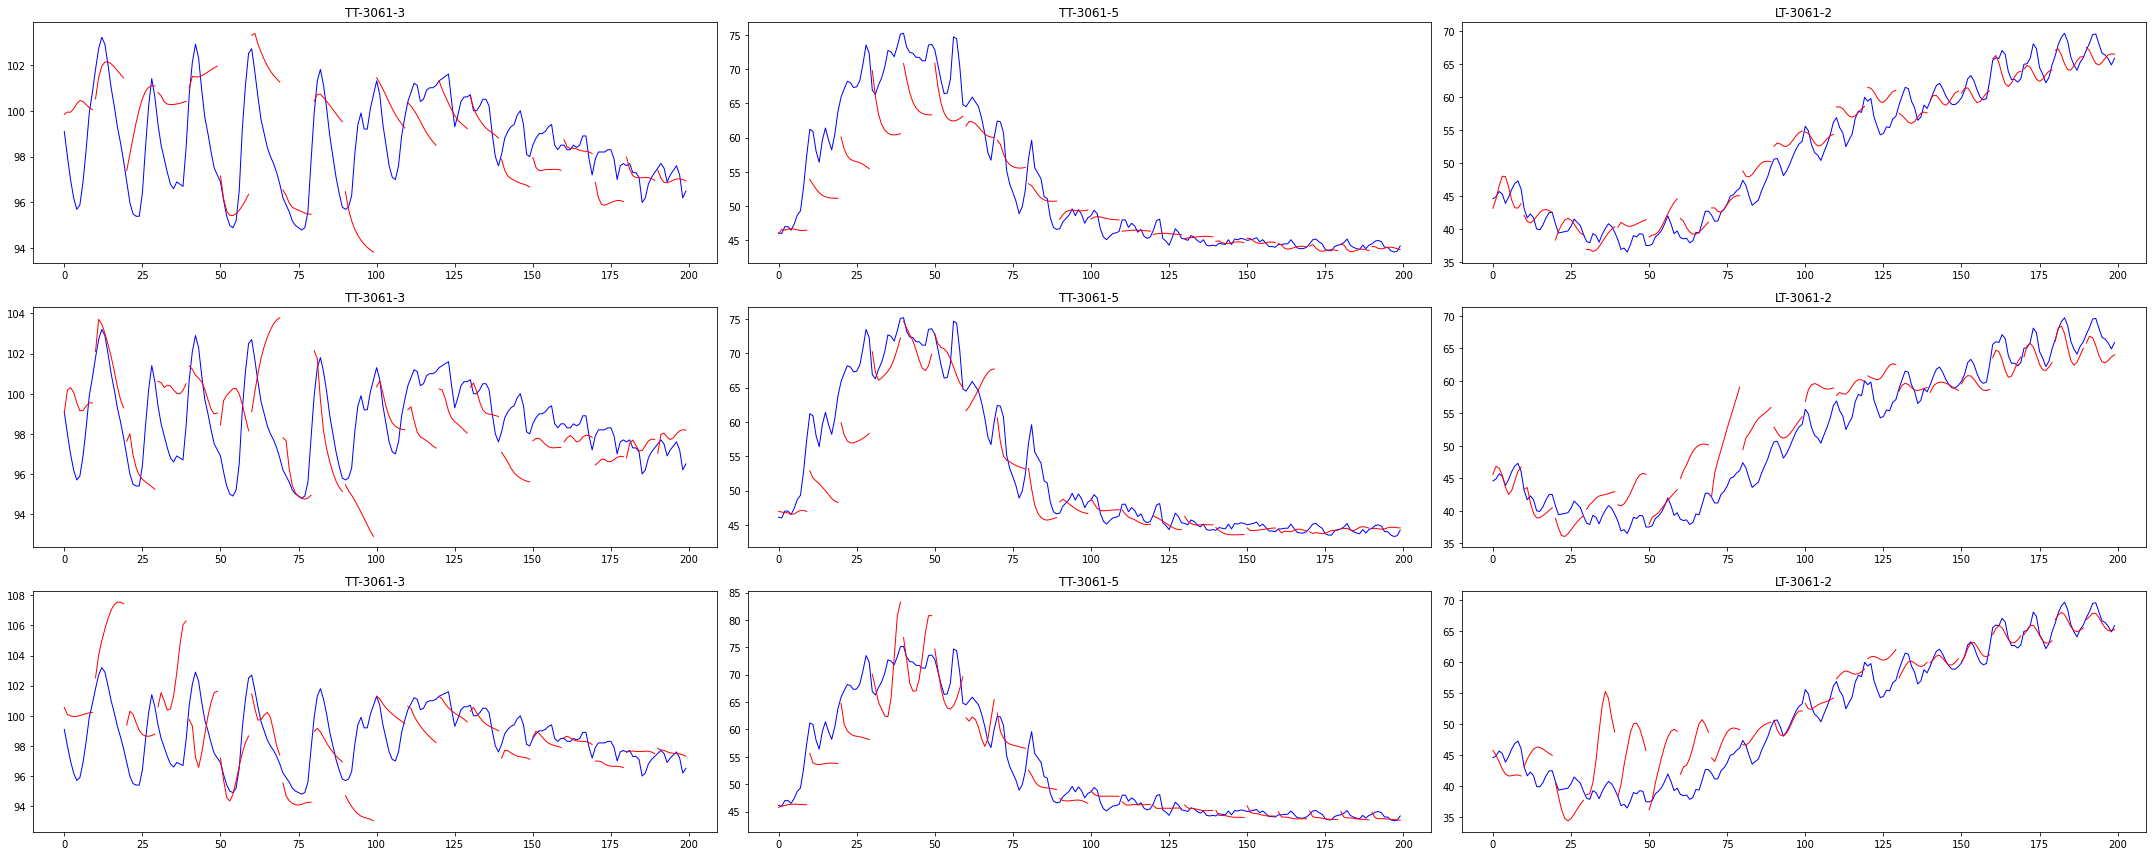

start_idx: 3400


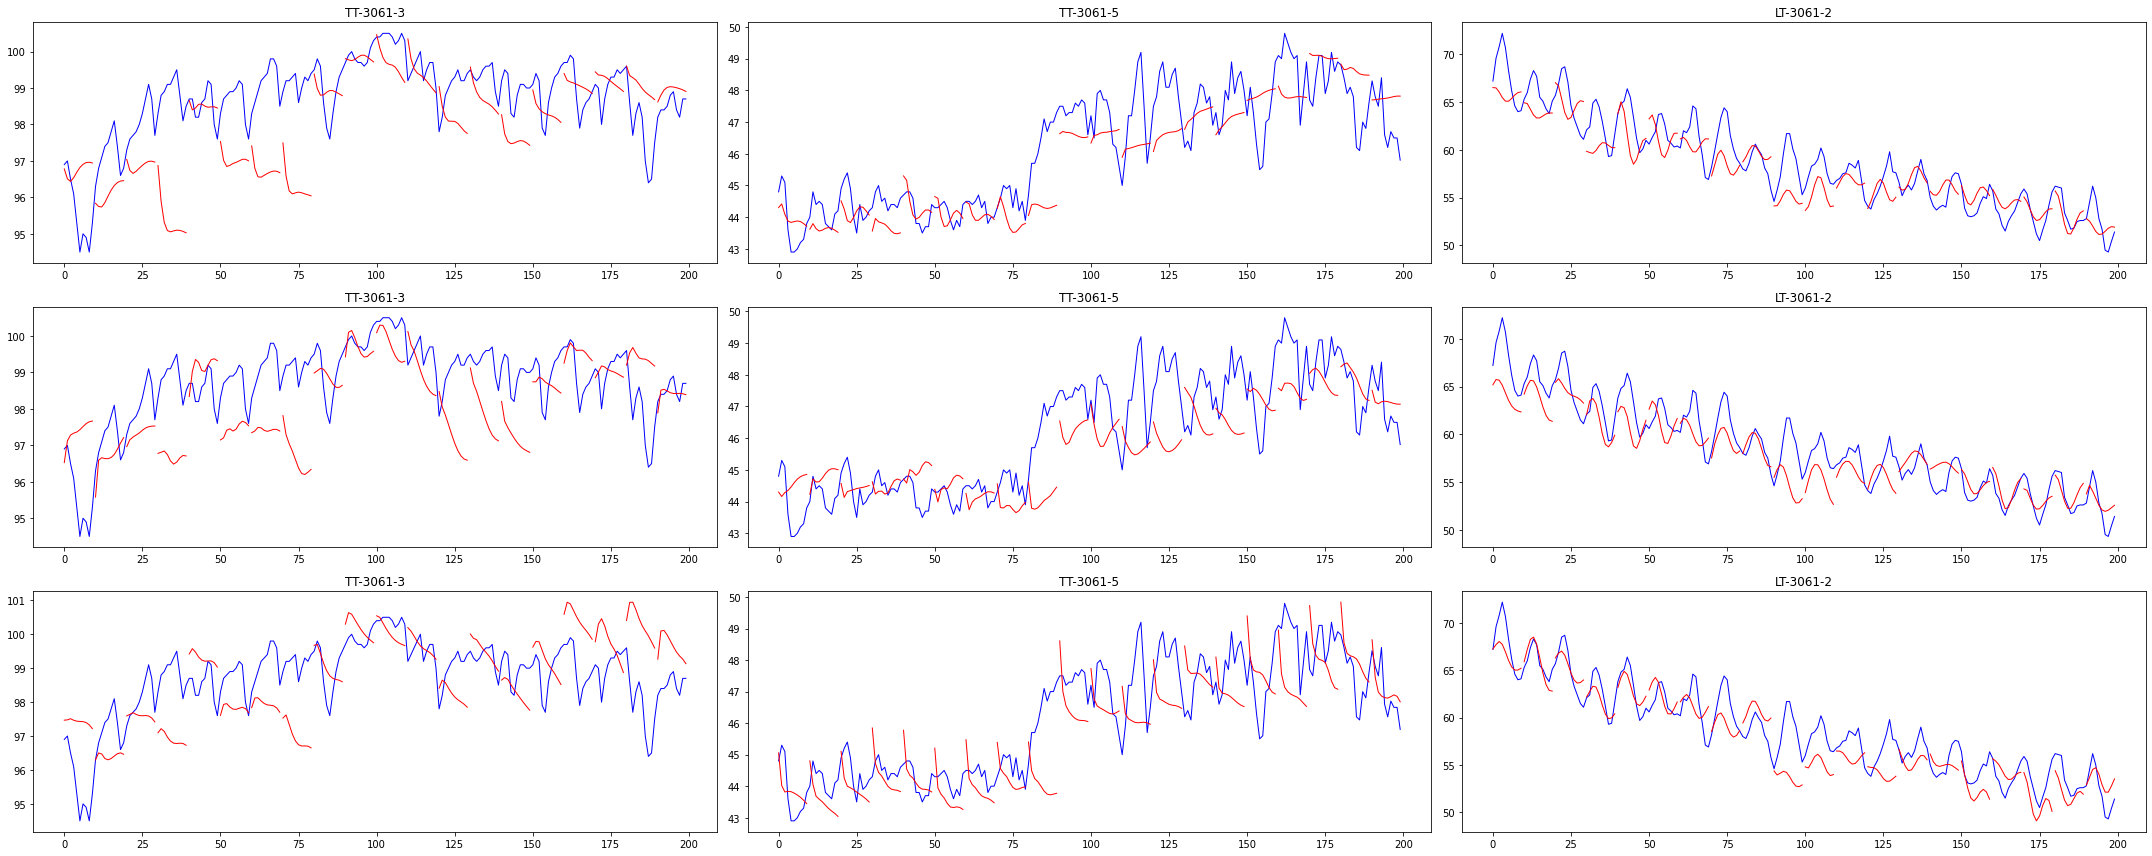

start_idx: 3600


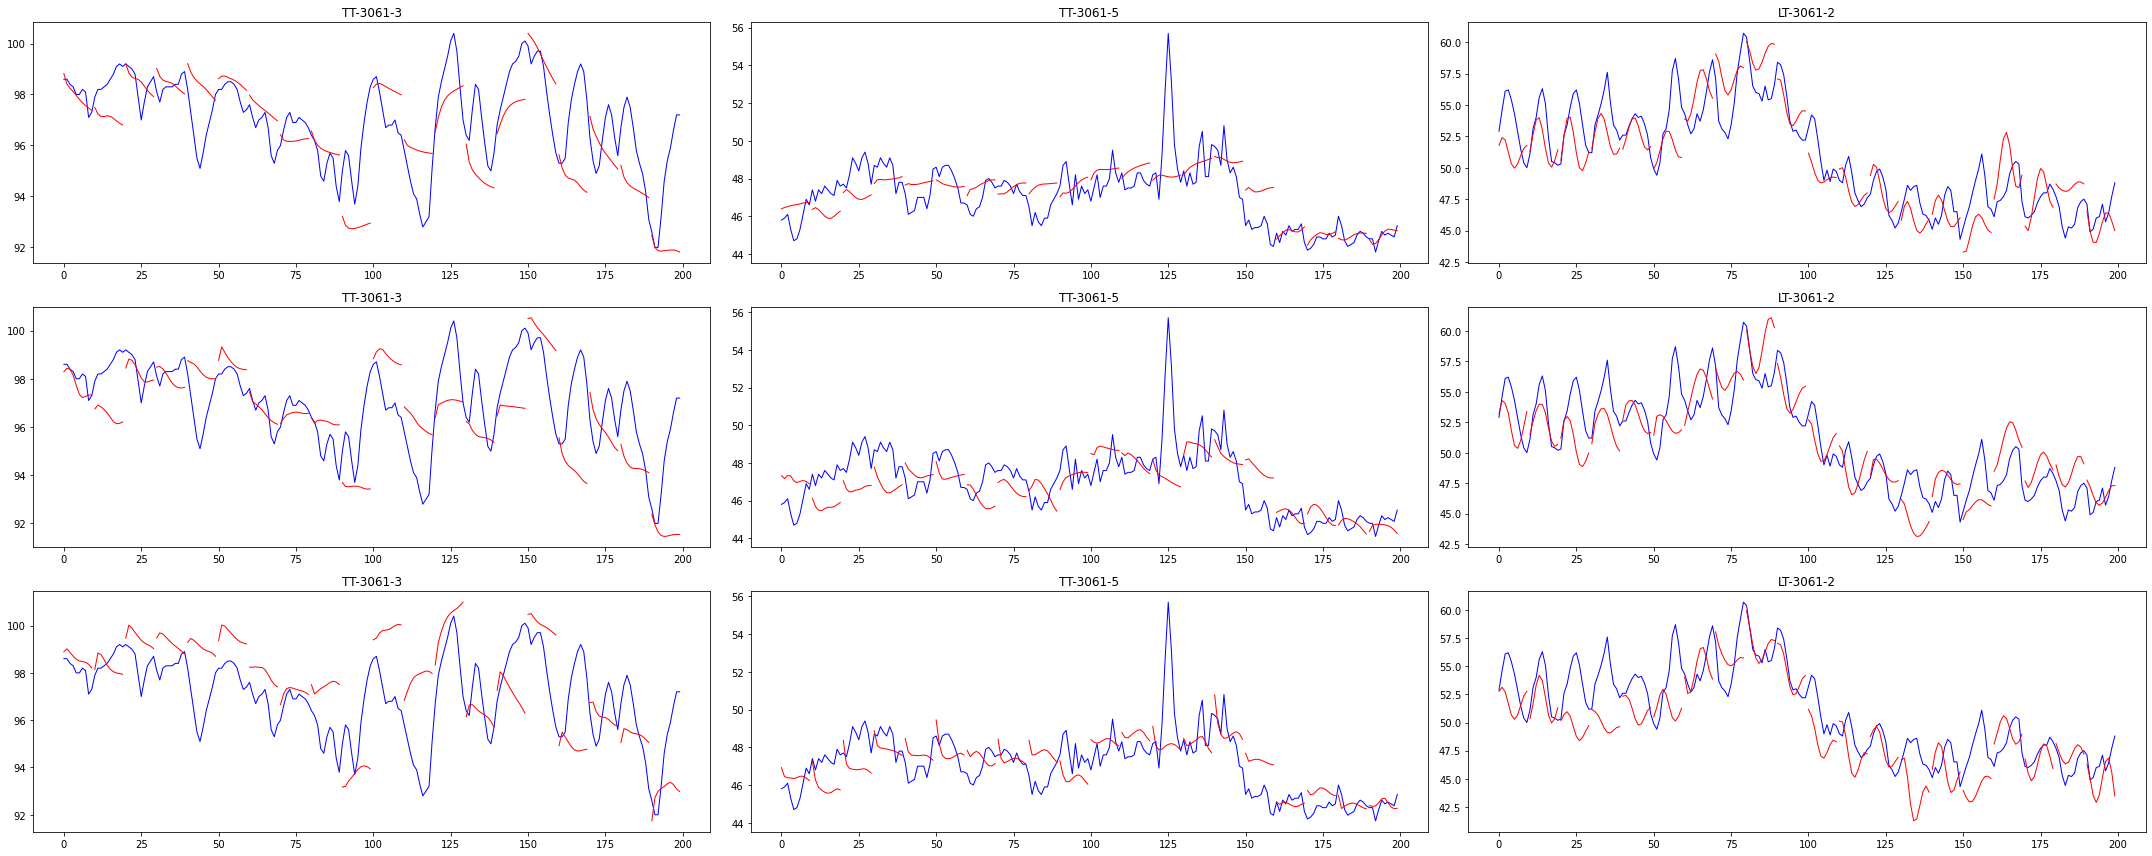

start_idx: 3800


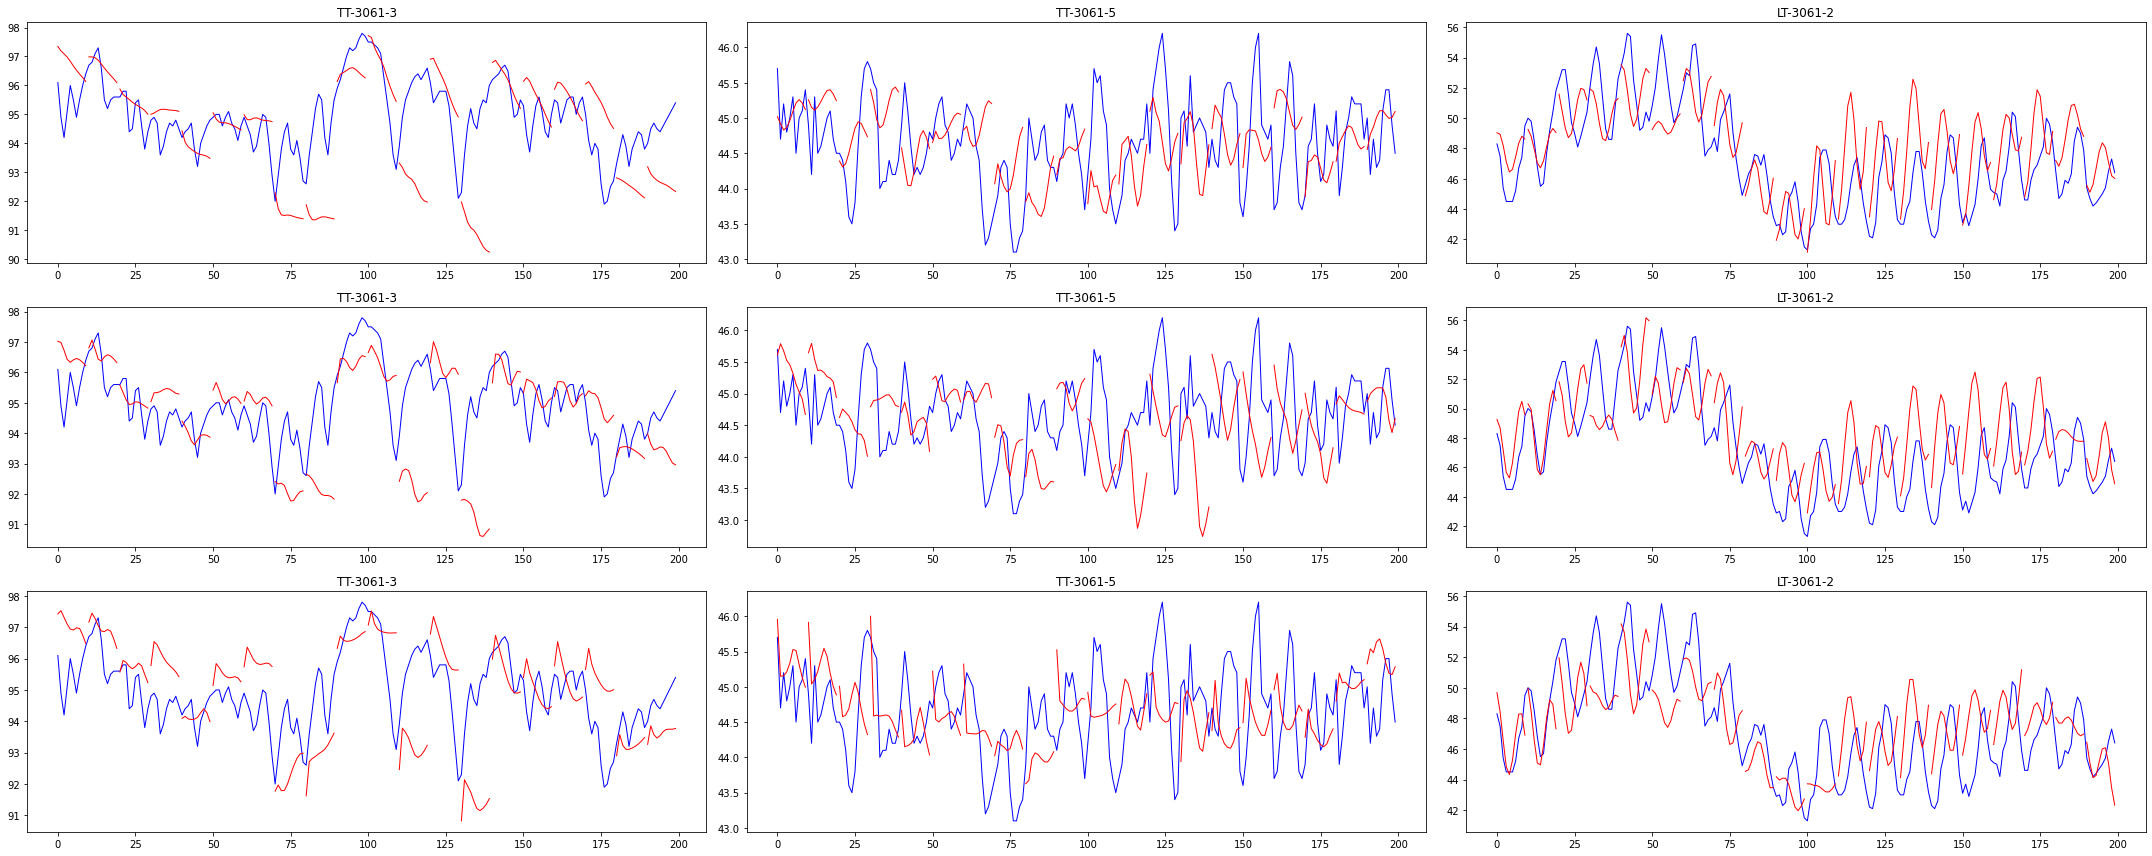

start_idx: 4000


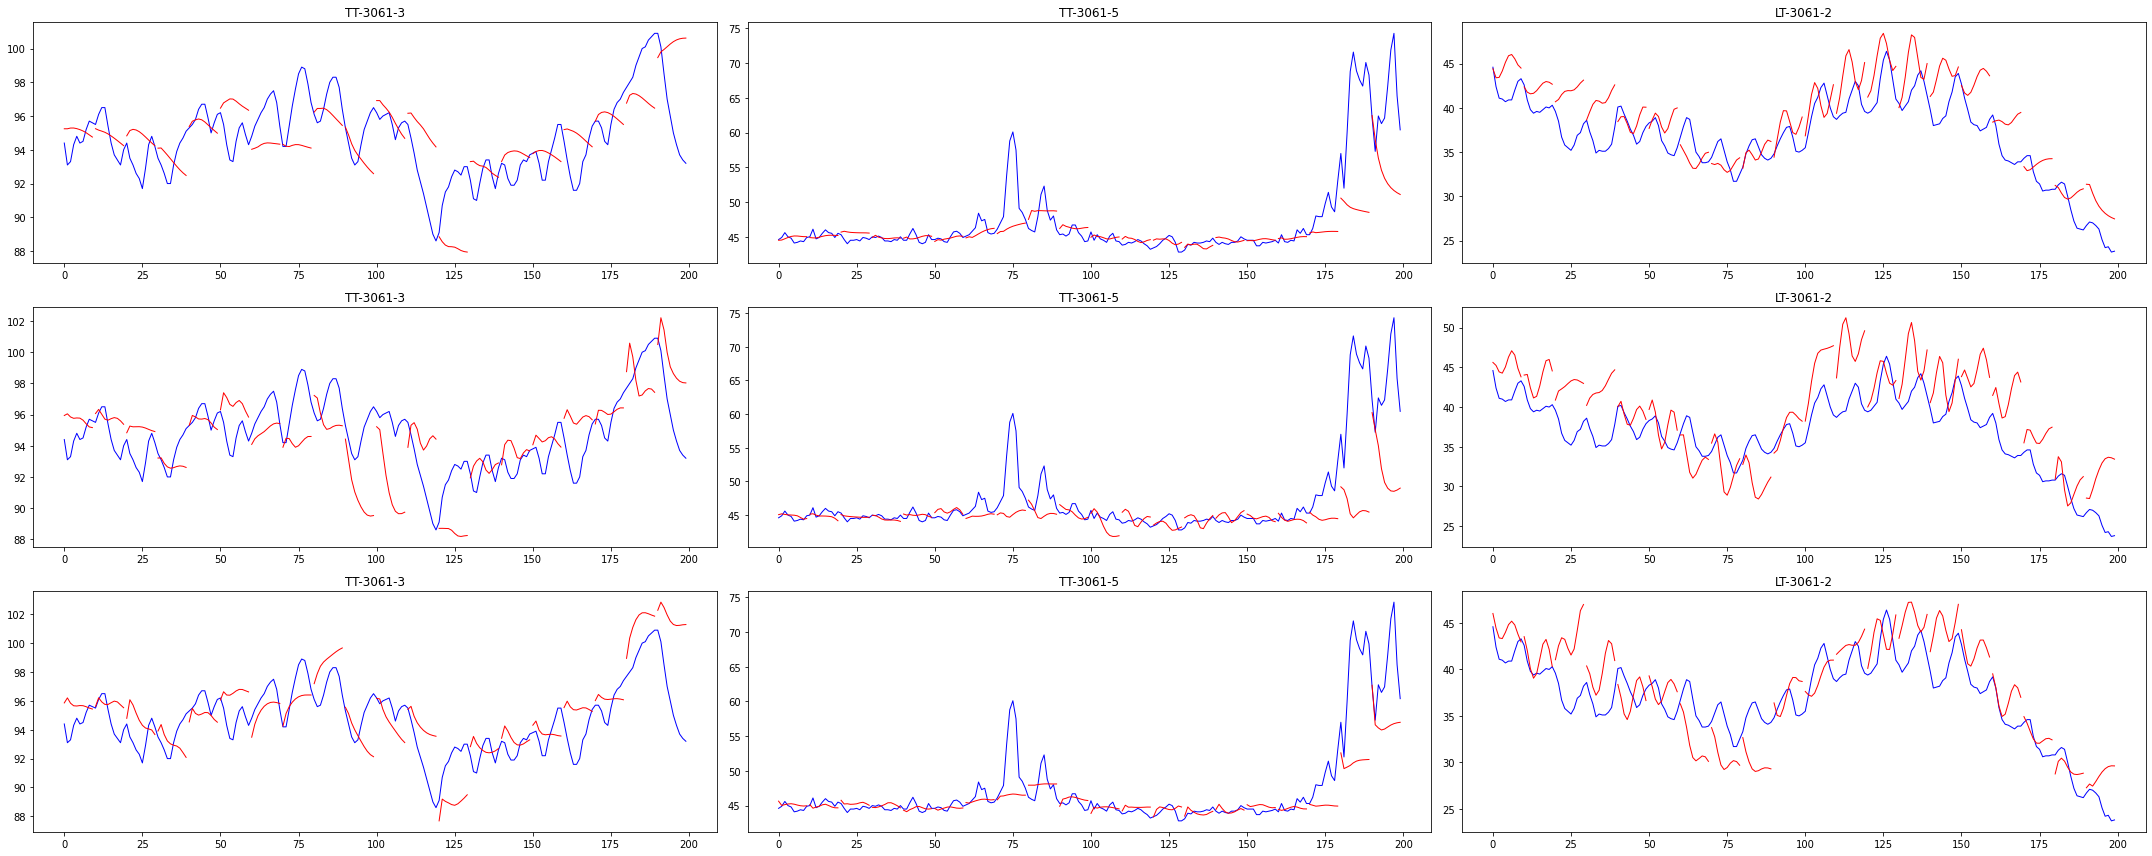

start_idx: 4200


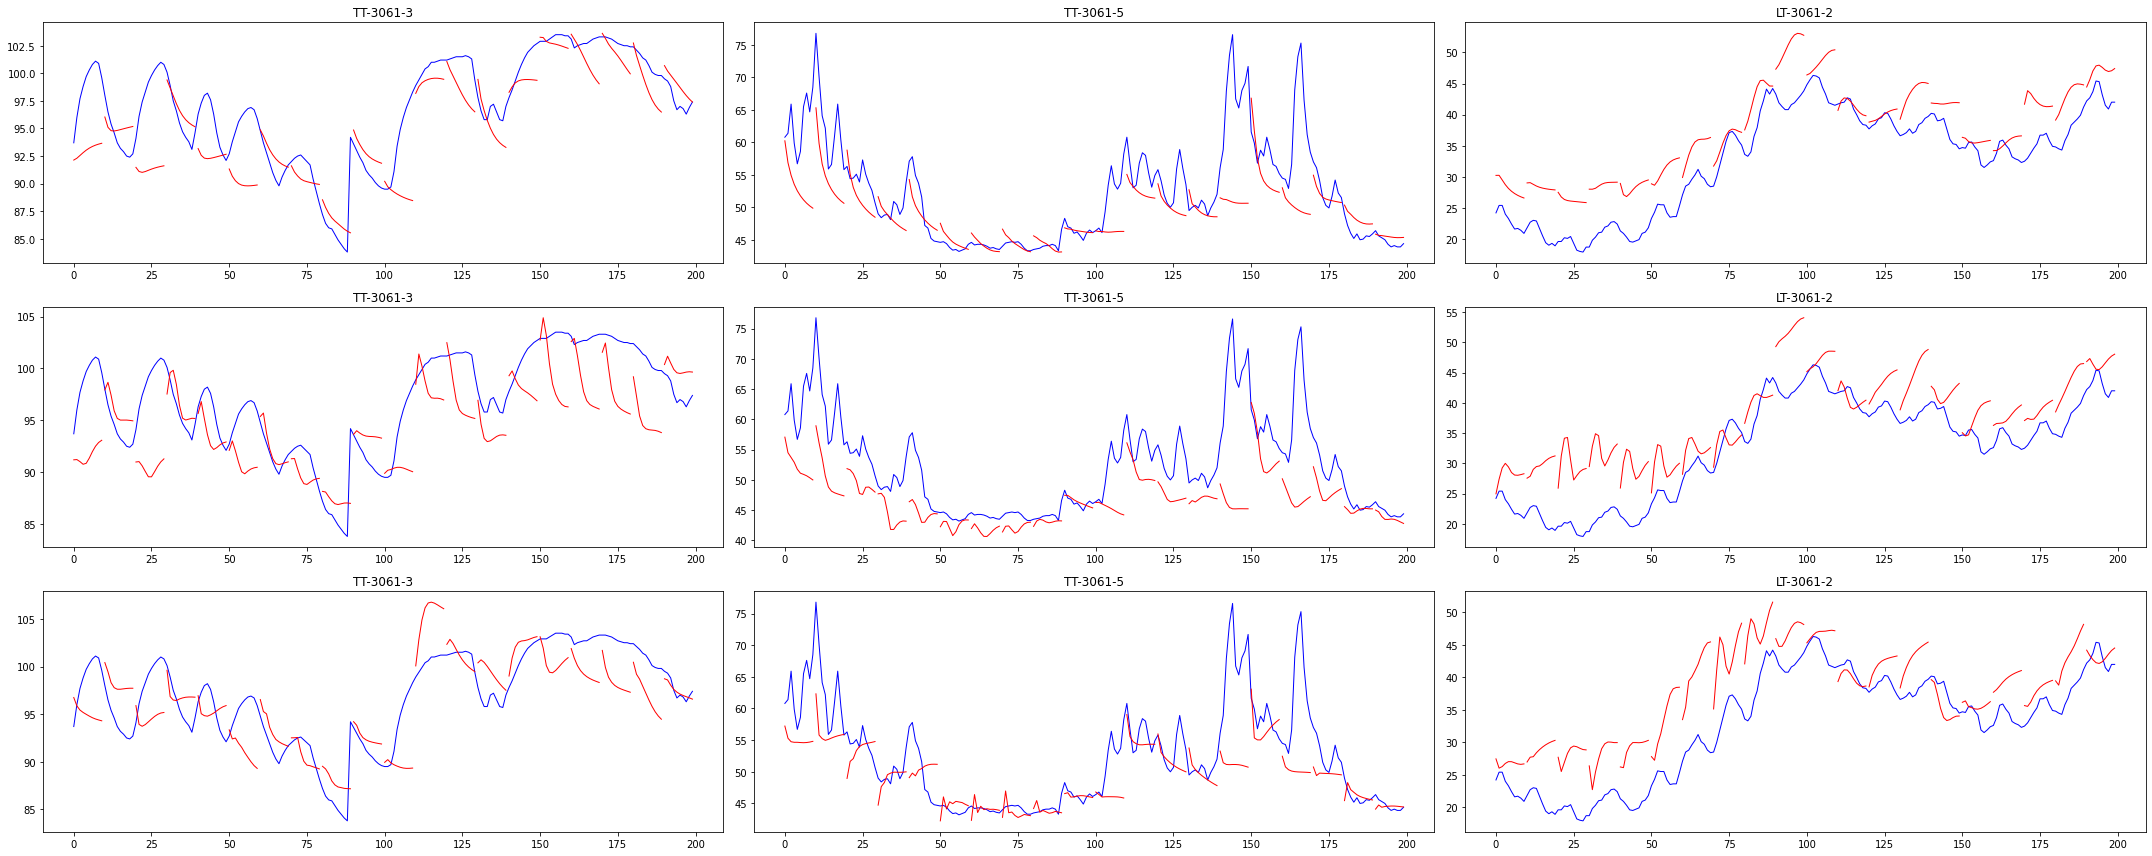

start_idx: 4400


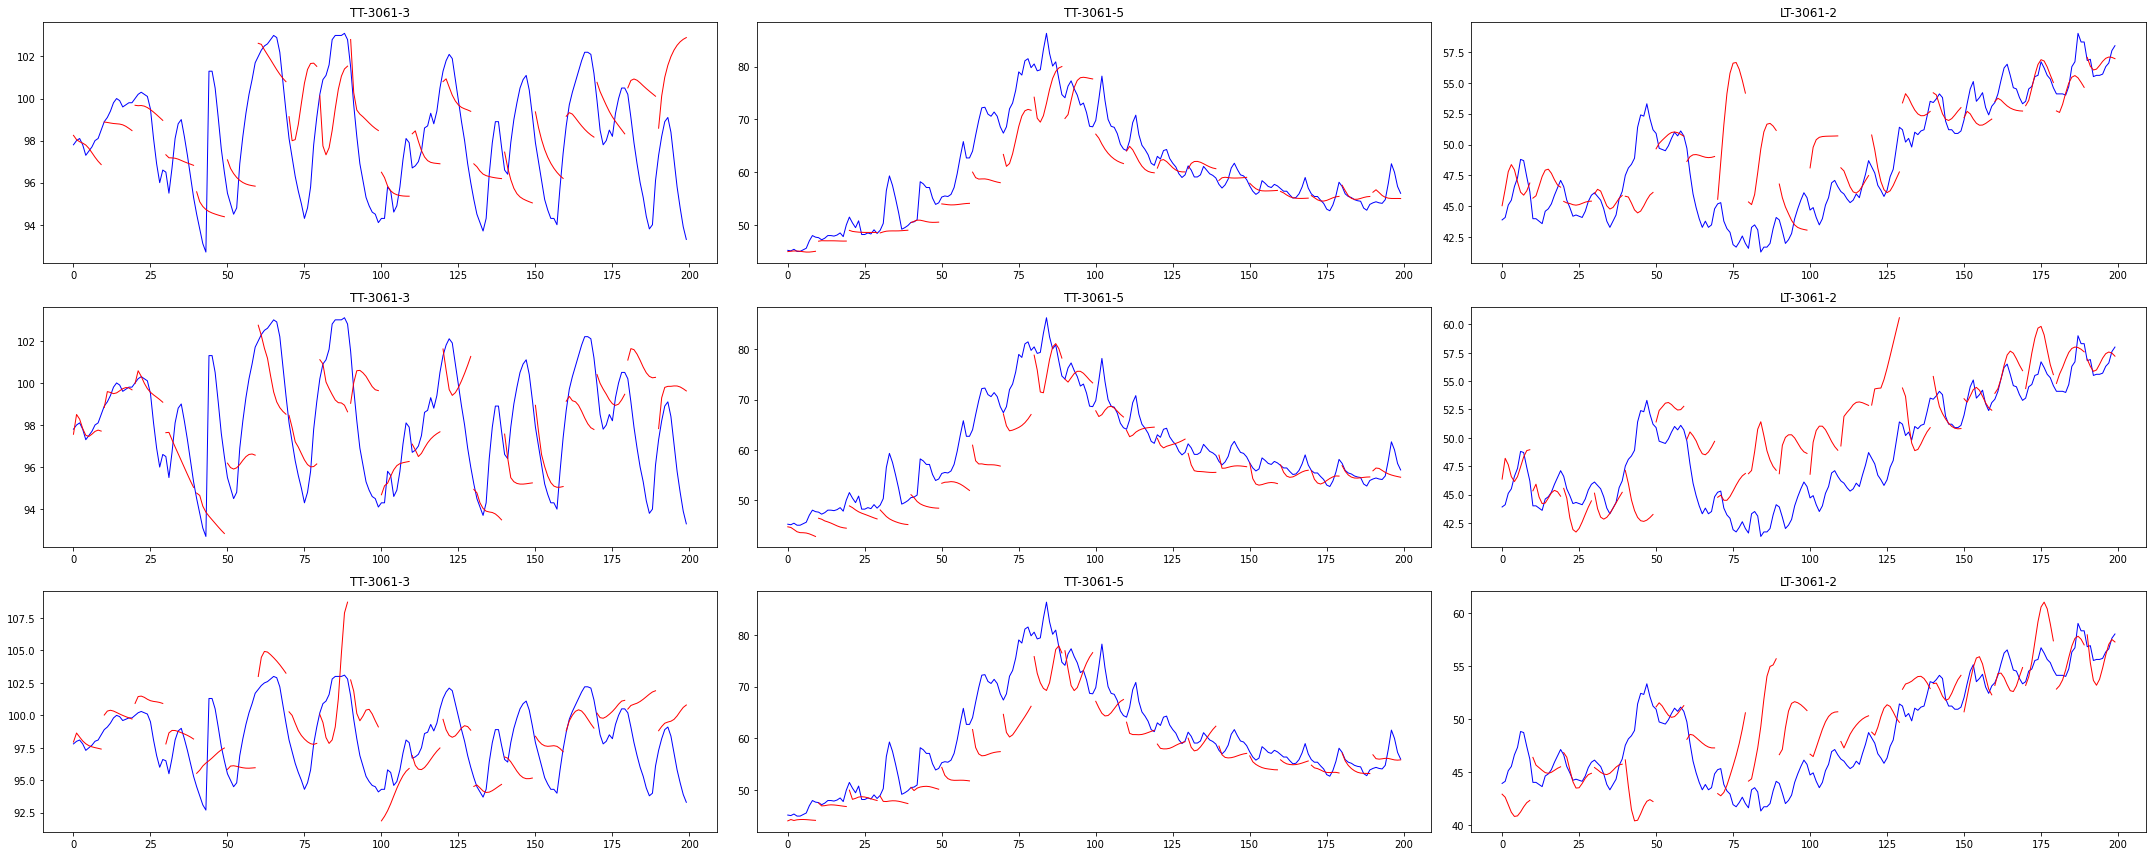

start_idx: 4600


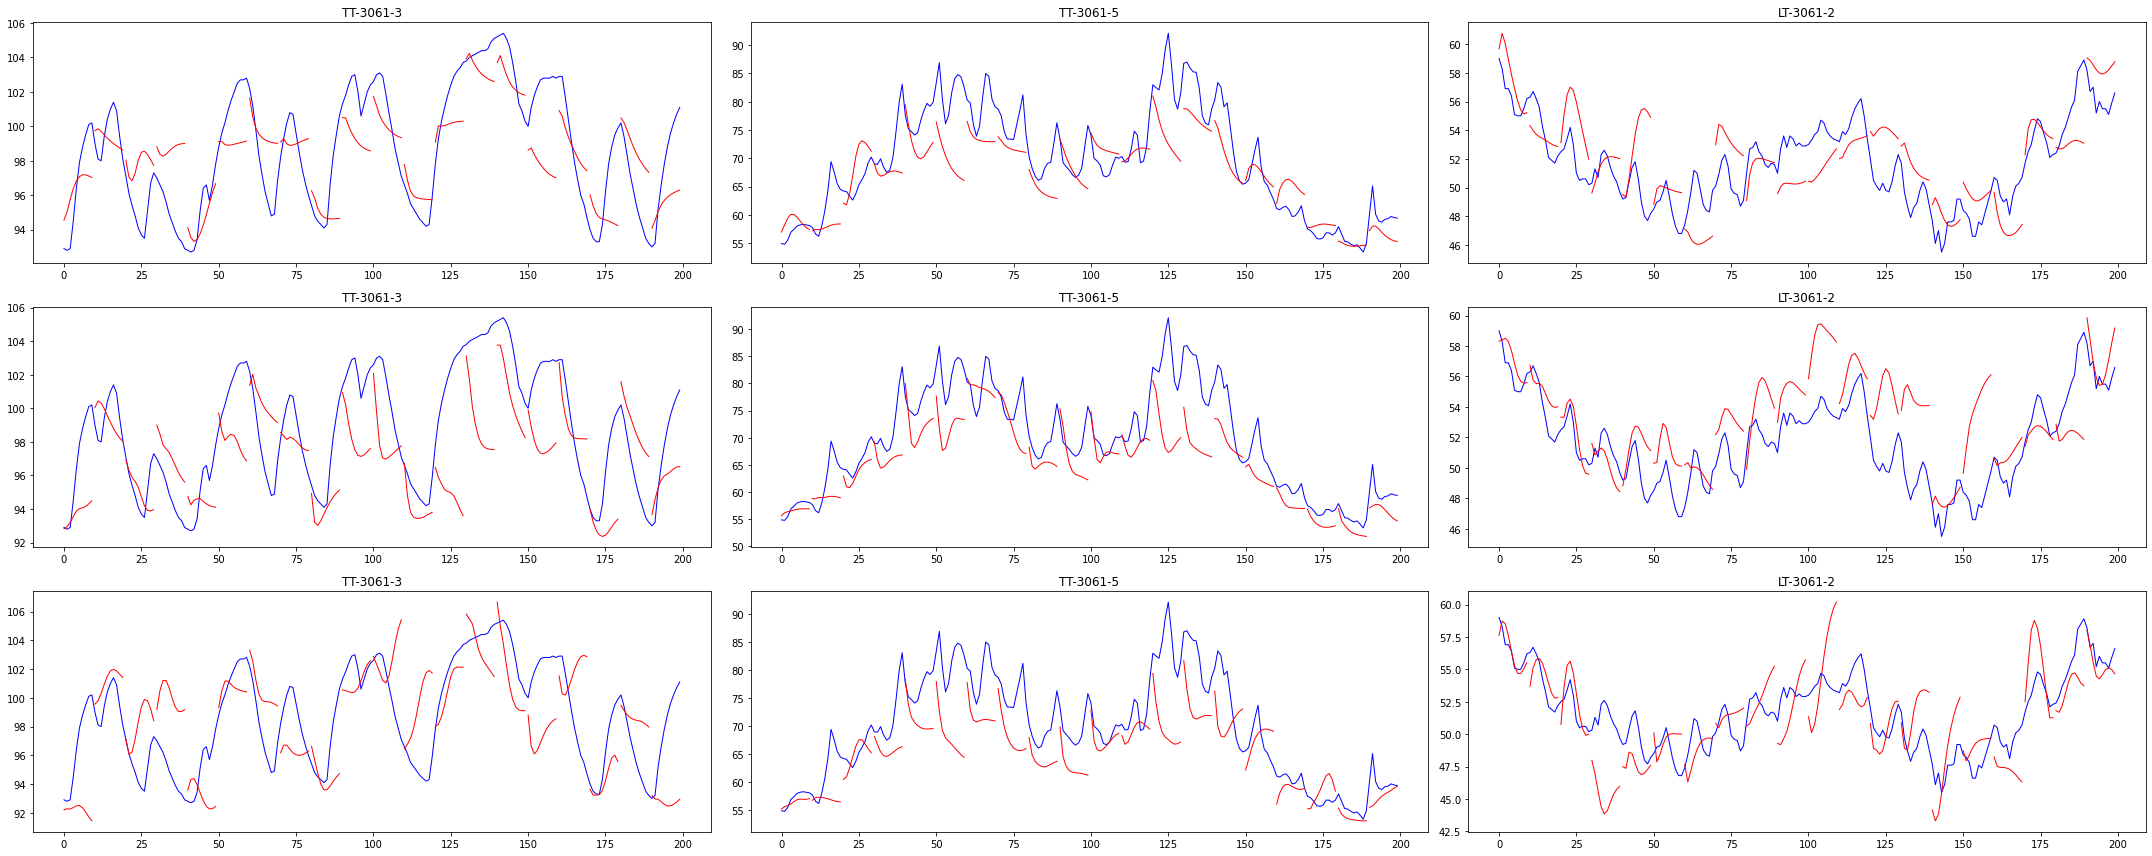

start_idx: 4800


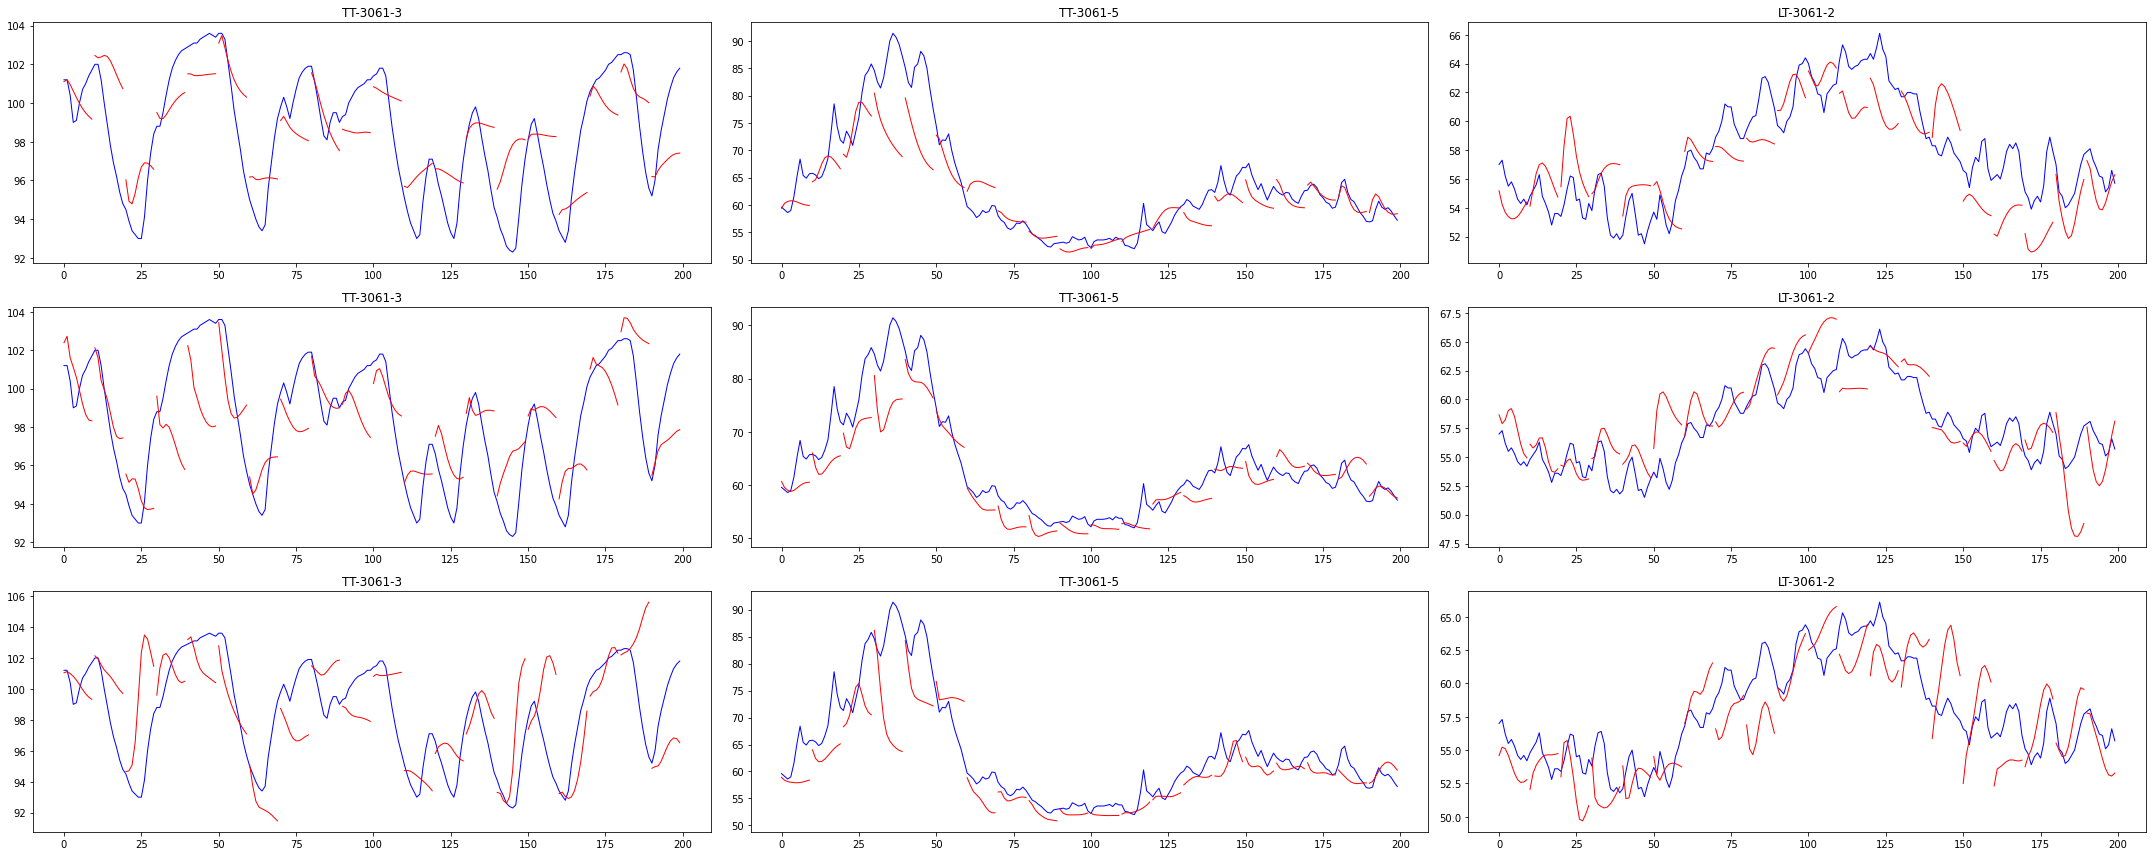

start_idx: 5000


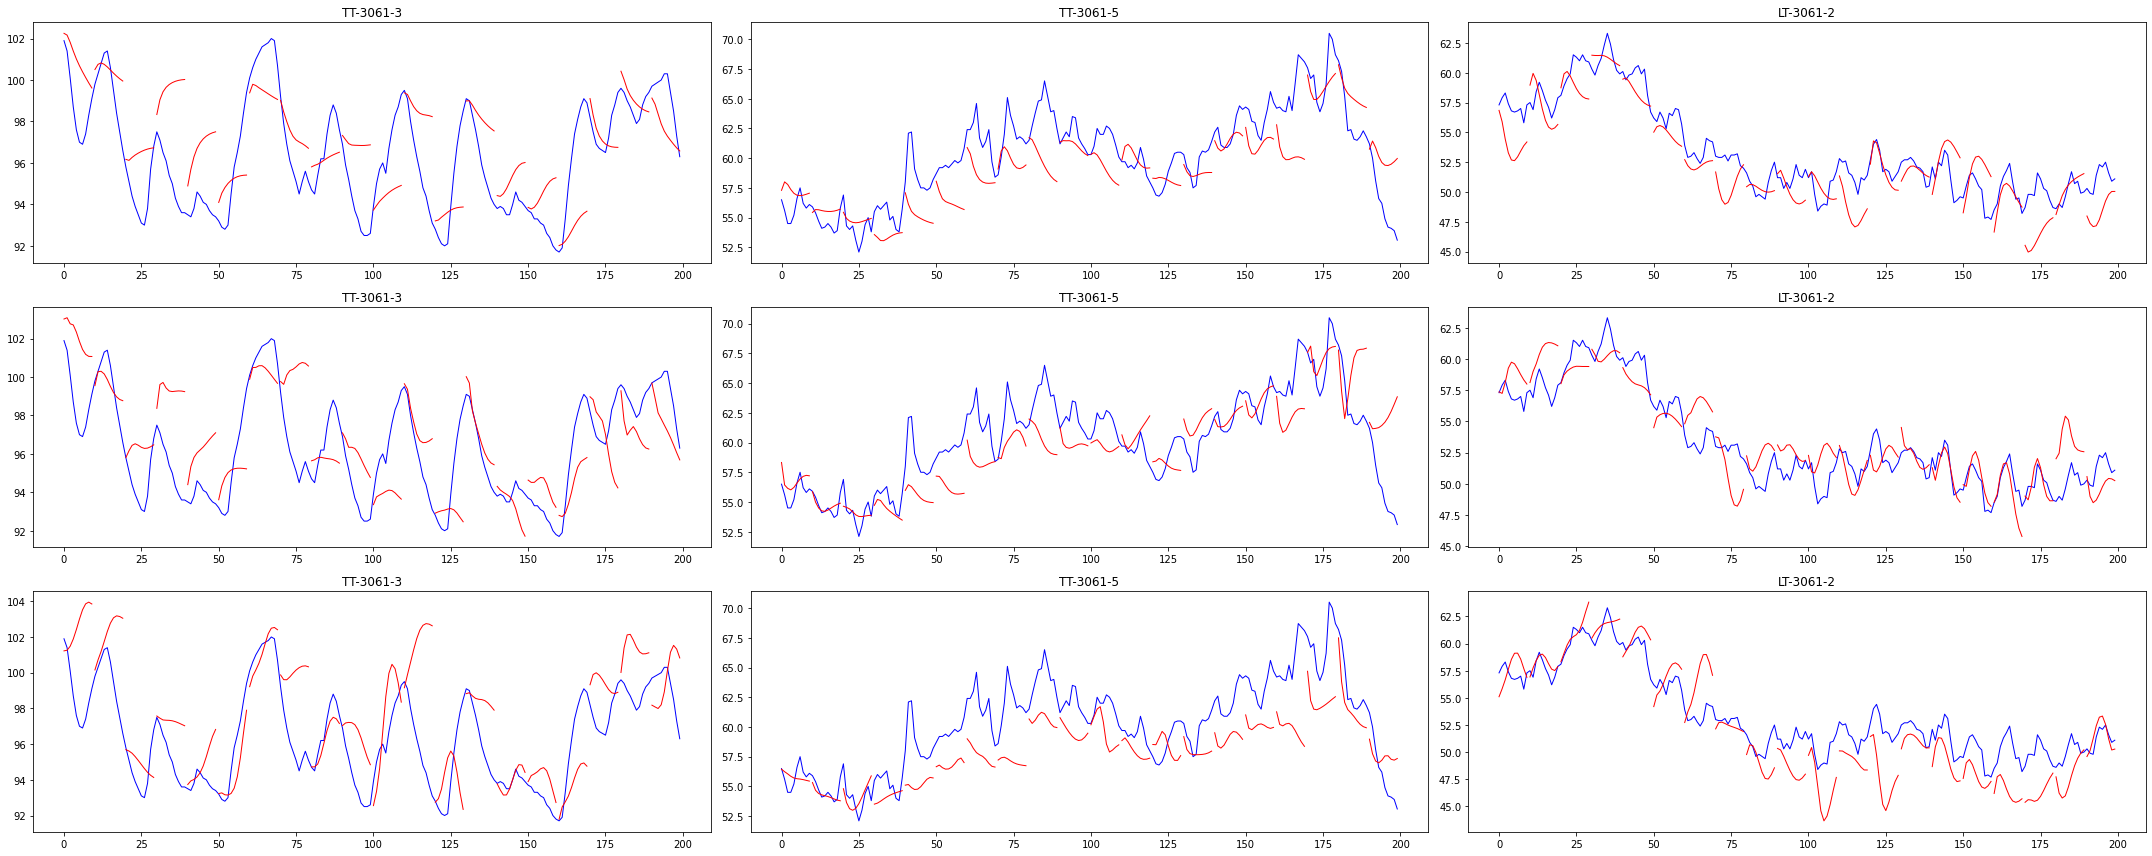

start_idx: 5200


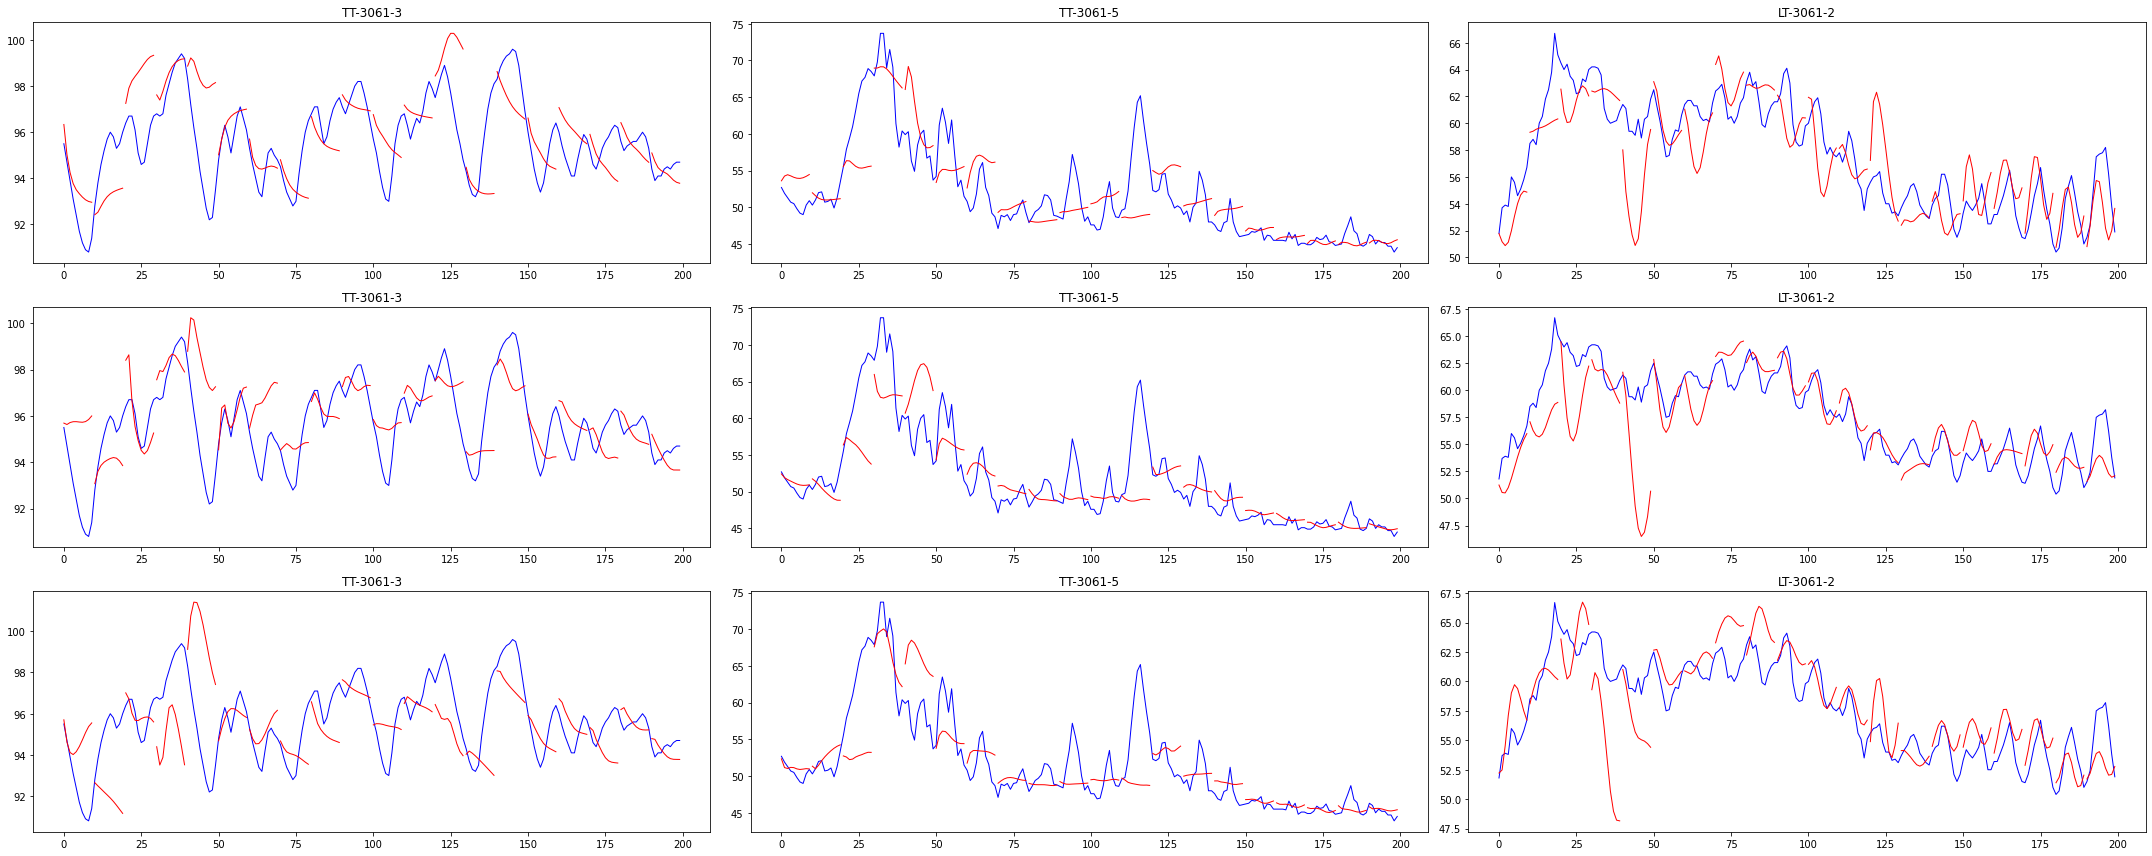

start_idx: 5400


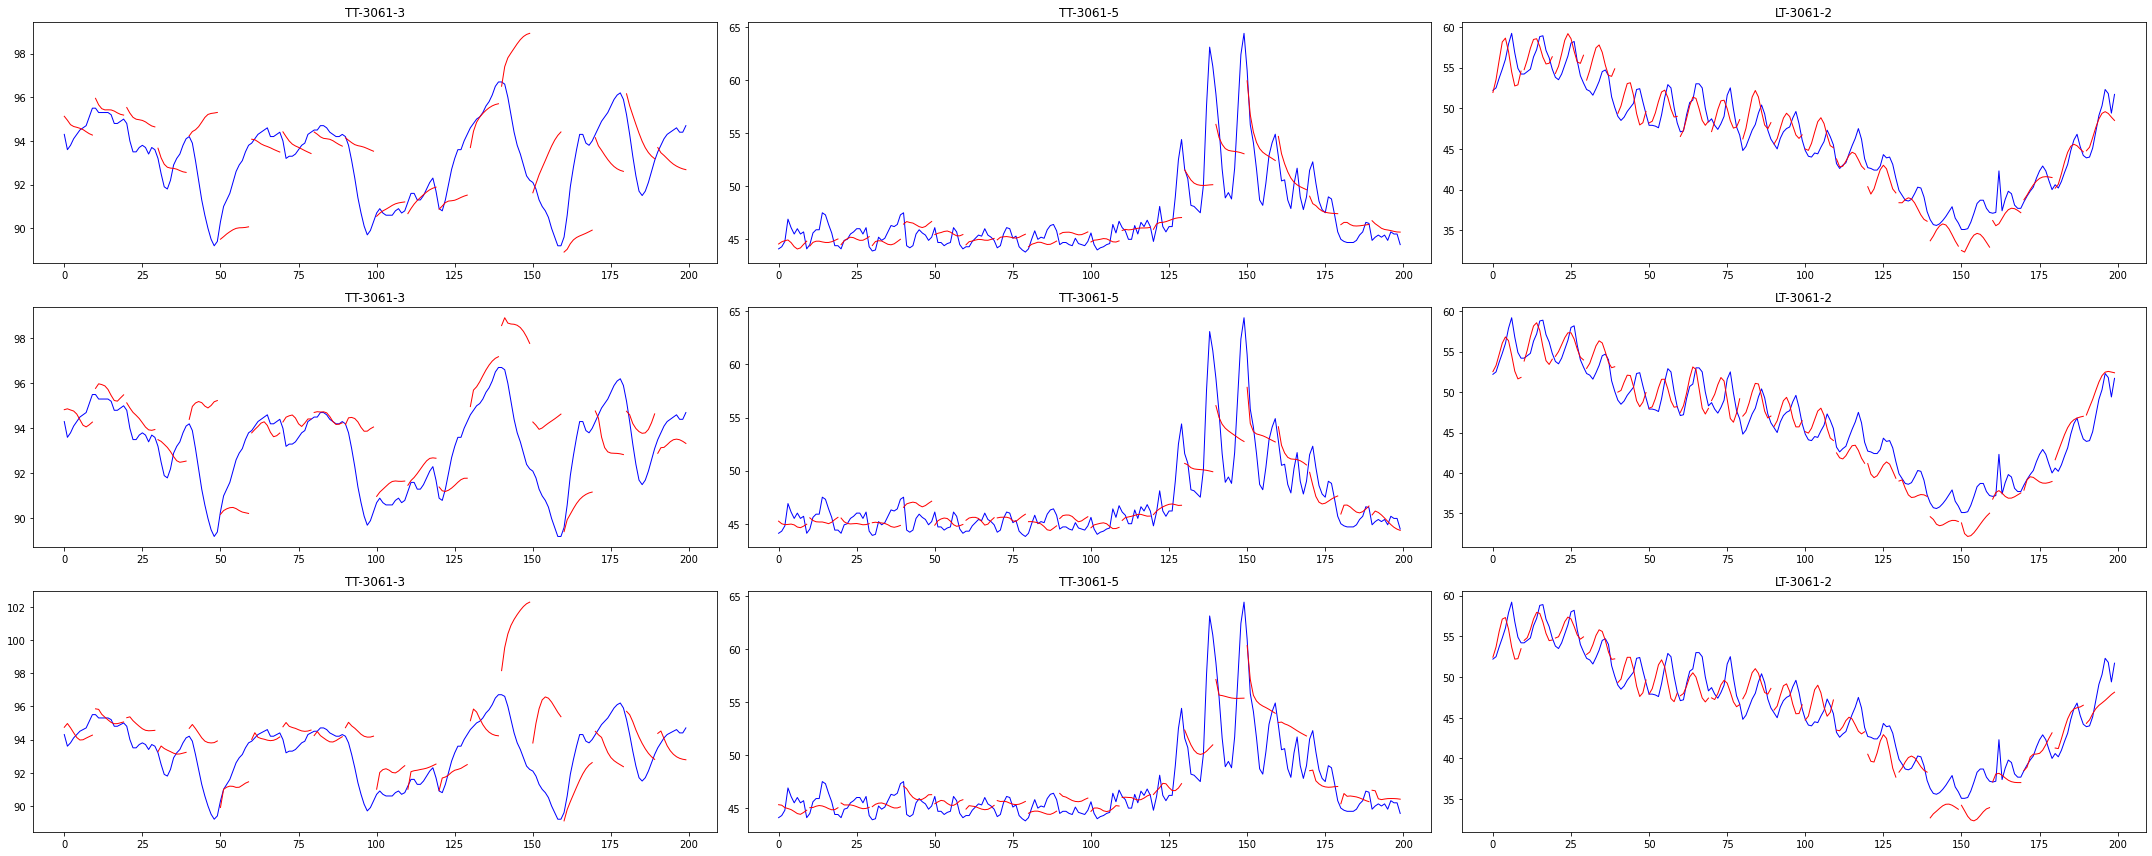

start_idx: 5600


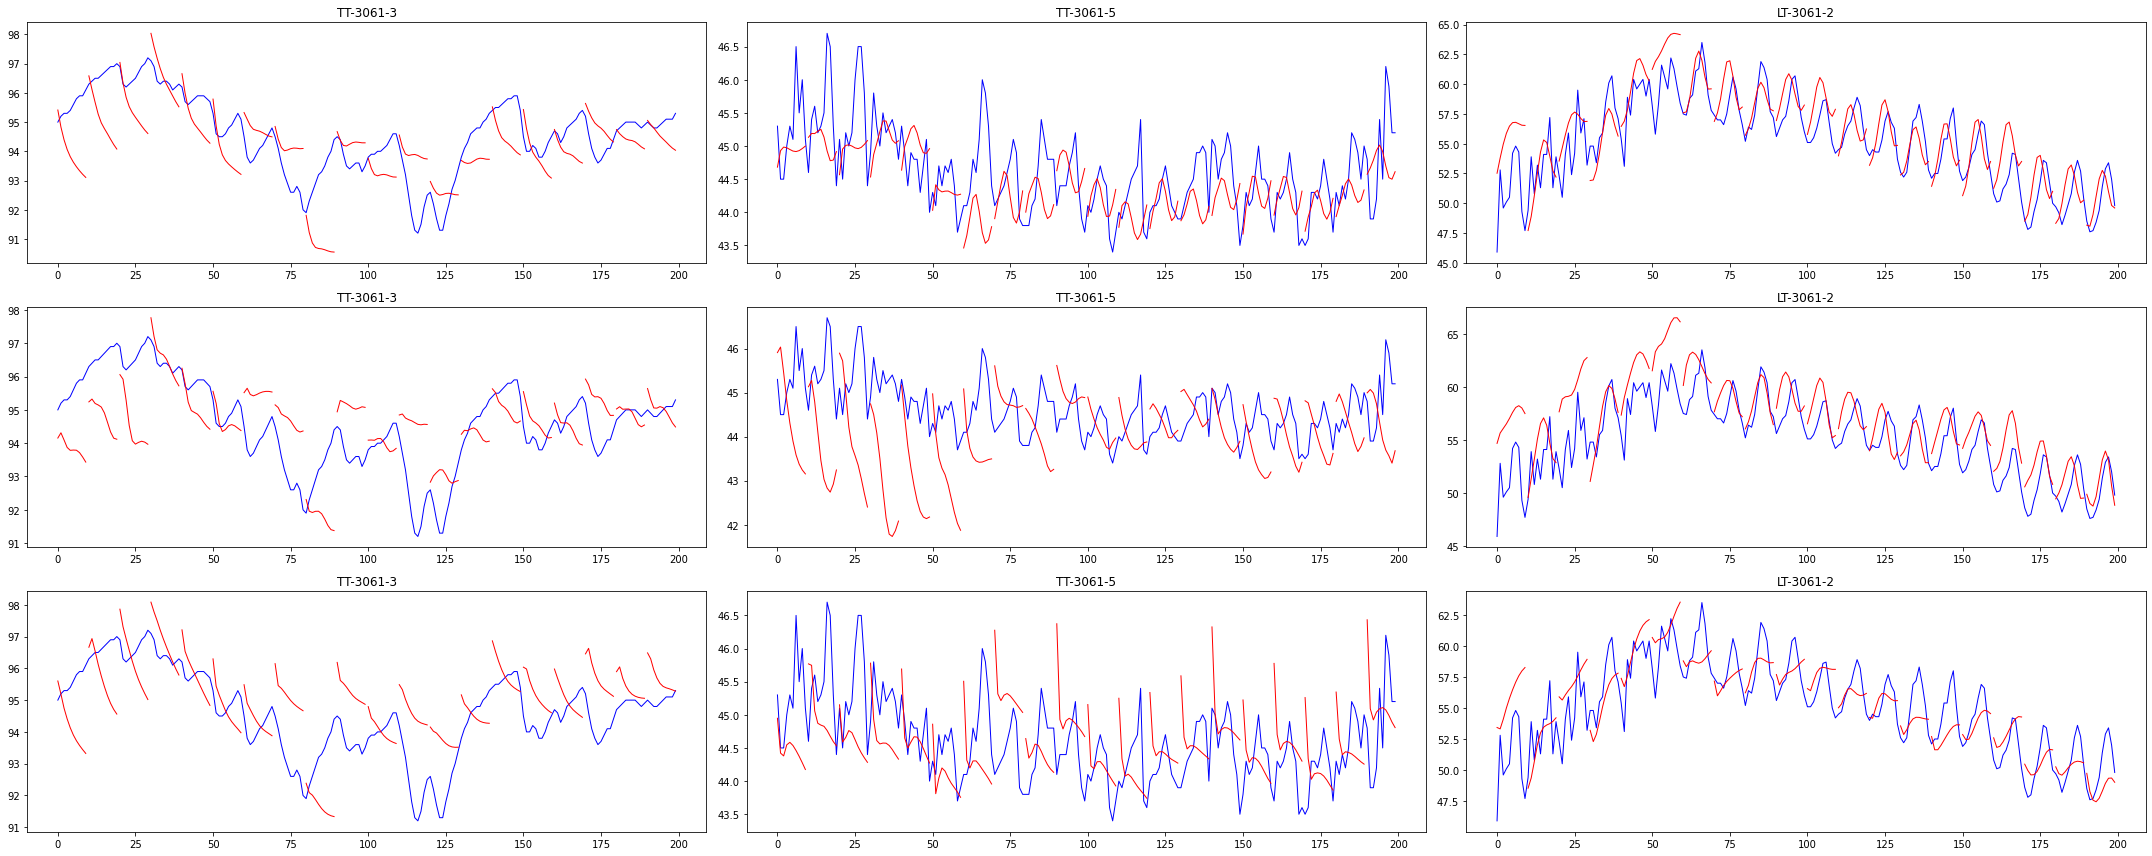

start_idx: 5800


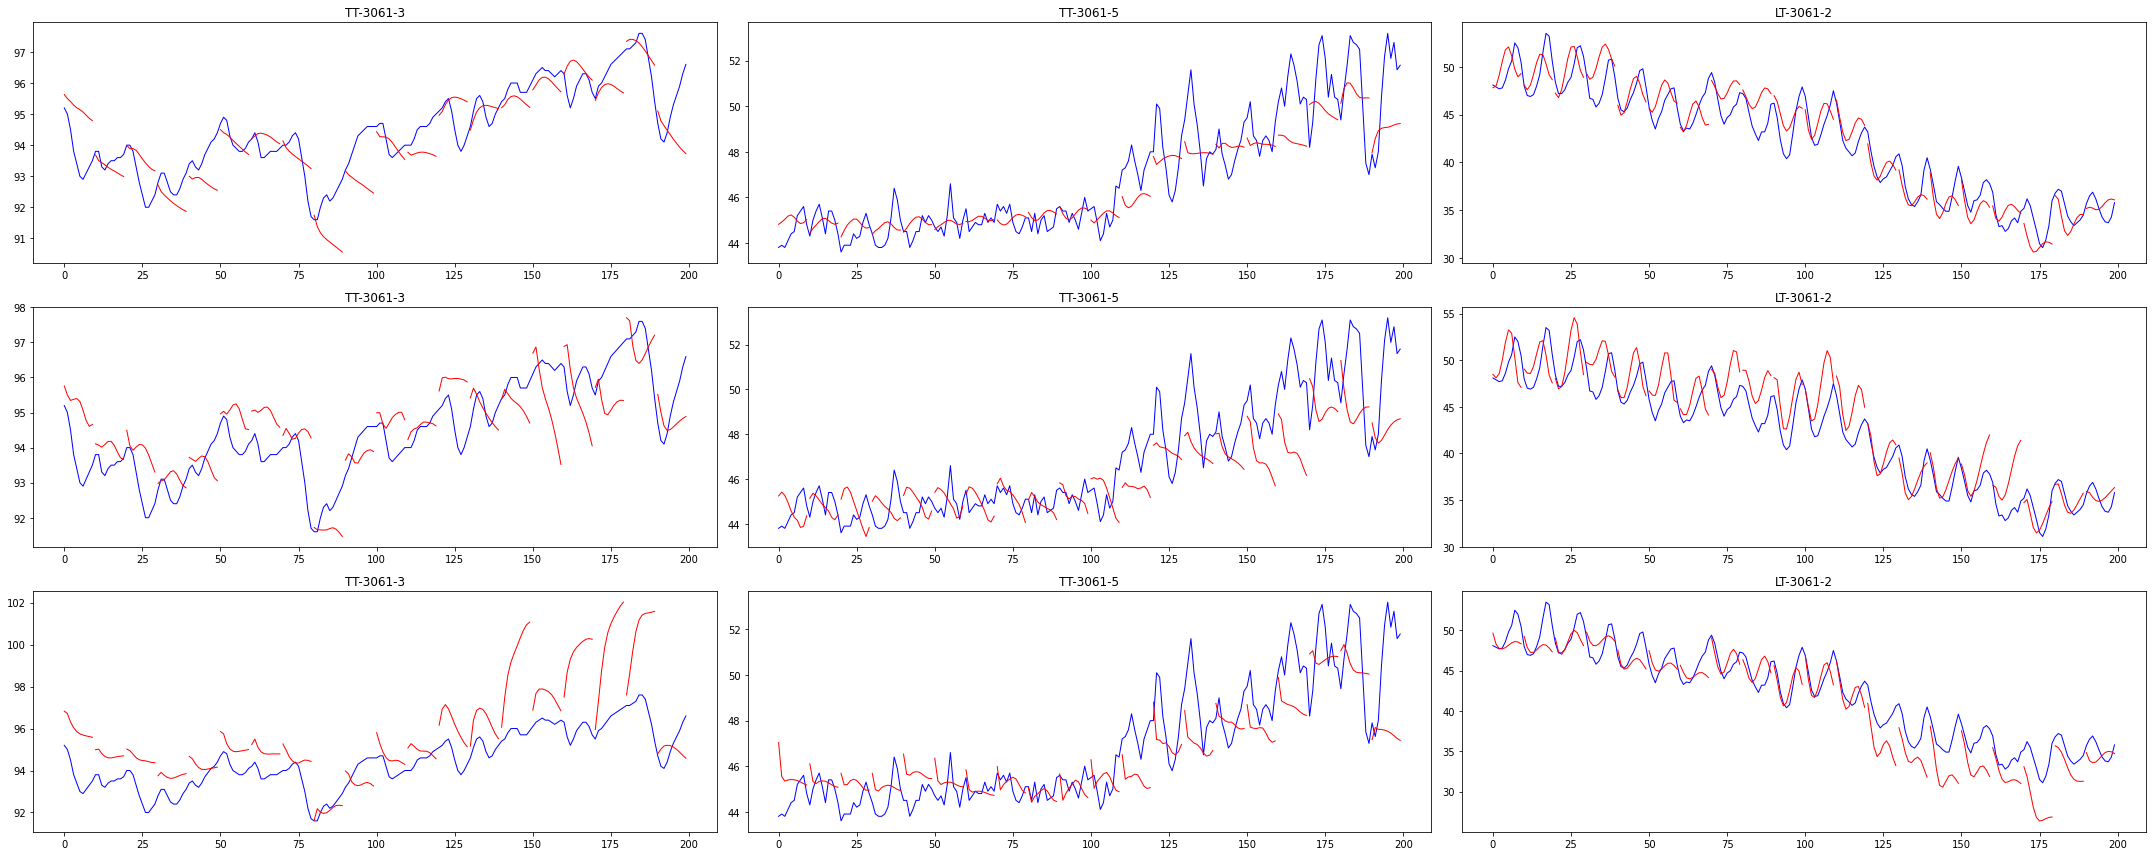

In [32]:
model_list = ['datt_seq2seq_gru', 'att_seq2seq_gru', 'seq2seq_gru']
for model_num in range(3):
    # RNN class 생성
    RNN_Model = rnn.RNN(history_series, history_var, future_series, future_var)
    RNN_Model.train_test(test_size=test_size, test_num=test_num)

    # 검증 데이터 스플릿
    valid_size = RNN_Model.history_test.shape[0]/RNN_Model.history_train.shape[0]
    RNN_Model.train_valid(valid_size=valid_size)

    # 데이터 스케일링
    RNN_Model.scaling()
        
    model_type = model_list[model_num]
    RNN_Model.build_model(num_layers=num_layers, num_neurons=num_neurons, dense_layers=dense_layers, dense_neurons=dense_neurons, model_type=model_type, factor=factor)

    model_number = 6
    model_name = f"{history_size}_{future_size}_{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{att_type}_{delta}_{model_number}"
    RNN_Model.model.load_weights(f"./model/{model_name}.h5")
    
    if model_num == 0:
        predict_wt = RNN_Model.model.predict(RNN_Model.history_test_sc)
        predict_sc = predict_wt/RNN_Model.factor
        _, predict_datt = RNN_Model.unscaling(RNN_Model.history_test_sc, predict_sc)
    elif model_num == 1:
        predict_sc = RNN_Model.model.predict(RNN_Model.history_test_sc)
        _, predict_att = RNN_Model.unscaling(RNN_Model.history_test_sc, predict_sc)
    elif model_num == 2:
        predict_sc = RNN_Model.model.predict(RNN_Model.history_test_sc)
        _, predict_seq = RNN_Model.unscaling(RNN_Model.history_test_sc, predict_sc)
actual_sc = RNN_Model.future_test_sc
_, actual = RNN_Model.unscaling(RNN_Model.history_test_sc, actual_sc)
    
target_len = 200

for start_target in range(0, 6000, target_len):
    end_target = start_target + target_len
    figure_name = f'figure_5_prediction_plot_{start_target}'
    print(f"start_idx: {start_target}")
    plt.figure(figsize=(10*len(future_var),4*3))
     
    for model_num in range(len(model_list)):
        for var_num in range(len(future_var)):
            actual_target = actual[start_target:end_target, 0, var_num]
            if model_num == 0:
                predict_target = predict_datt[start_target:end_target, :, var_num]    
            elif model_num == 1:
                predict_target = predict_att[start_target:end_target, :, var_num]   
            elif model_num == 2:
                predict_target = predict_seq[start_target:end_target, :, var_num]   
                
            plt.subplot(len(model_list), len(future_var), model_num*len(future_var)+var_num+1)
            plt.plot(np.arange(0,len(actual_target)), actual_target, label='actual', linewidth=1, color='b')
            for start_idx in range(0, len(predict_target), future_size):
                end_idx = start_idx + future_size
                predict_plot = predict_target[start_idx, :]
                plt.plot(np.arange(start_idx, end_idx), predict_plot, label='prediction', linewidth=1, color='r')
            plt.title(f'{future_var[var_num]}')
    plt.tight_layout()
    if not exists(f'./figure/{figure_name}.png') or update:
        savefile(_, './figure', figure_name, 'figure')
    plt.show()